## 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score,
    roc_auc_score,
    roc_curve,
    matthews_corrcoef,
    balanced_accuracy_score,
    precision_recall_curve,
    average_precision_score,
    cohen_kappa_score
)
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## 2. Load Data

In [2]:
# Load flood risk data
flood_df = pd.read_csv('../data/flood_risk_data/sri_lanka_flood_risk_dataset_25000.csv')
print(f"Flood Risk Data Shape: {flood_df.shape}")
print("\nFirst few rows:")
flood_df.head()

FileNotFoundError: [Errno 2] No such file or directory: '../data/flood_risk_data/sri_lanka_flood_risk_dataset_25000.csv'

In [ ]:
# Load weather data
weather_df = pd.read_csv('../data/weather_data/SriLanka_Weather_Dataset.csv')
print(f"Weather Data Shape: {weather_df.shape}")
print("\nFirst few rows:")
weather_df.head()

Weather Data Shape: (147480, 24)

First few rows:


,time,weathercode,temperature_2m_max,temperature_2m_min,temperature_2m_mean,apparent_temperature_max,apparent_temperature_min,apparent_temperature_mean,sunrise,sunset,...,precipitation_hours,windspeed_10m_max,windgusts_10m_max,winddirection_10m_dominant,et0_fao_evapotranspiration,latitude,longitude,elevation,country,city
0,2010-01-01,2,30.0,22.7,26.1,34.4,25.2,29.2,2010-01-01T00:52,2010-01-01T12:35,...,0.0,11.7,27.4,20,4.58,7.0,79.899994,16.0,Sri Lanka,Colombo
1,2010-01-02,51,29.9,23.5,26.2,33.8,26.2,29.8,2010-01-02T00:52,2010-01-02T12:36,...,1.0,13.0,27.0,24,3.84,7.0,79.899994,16.0,Sri Lanka,Colombo
2,2010-01-03,51,29.5,23.2,26.0,34.3,26.3,29.9,2010-01-03T00:53,2010-01-03T12:36,...,3.0,12.3,27.4,16,3.65,7.0,79.899994,16.0,Sri Lanka,Colombo
3,2010-01-04,2,28.9,21.9,25.3,31.6,23.4,27.8,2010-01-04T00:53,2010-01-04T12:37,...,0.0,17.0,34.6,356,3.79,7.0,79.899994,16.0,Sri Lanka,Colombo
4,2010-01-05,1,28.1,21.3,24.5,30.1,23.1,26.1,2010-01-05T00:53,2010-01-05T12:37,...,0.0,18.7,37.1,355,4.97,7.0,79.899994,16.0,Sri Lanka,Colombo


## 3. Merge Weather and Flood Risk Data for Time-Series Forecasting

**Goal**: Create a dataset that can predict future floods by combining:
- Historical weather patterns (temperature, rainfall, wind, etc.)
- Location-specific flood risk factors
- Temporal features for forecasting

In [ ]:
# Prepare weather data - convert time to datetime
weather_df['date'] = pd.to_datetime(weather_df['time'])
weather_df = weather_df.sort_values('date')

print("Weather Data Date Range:")
print(f"Start: {weather_df['date'].min()}")
print(f"End: {weather_df['date'].max()}")
print(f"\nUnique locations in weather data: {weather_df['city'].nunique()}")
print(f"Cities: {weather_df['city'].unique()}")

# Prepare flood data - convert generation_date to datetime
flood_df['event_date'] = pd.to_datetime(flood_df['generation_date'])
flood_df = flood_df.sort_values('event_date')

print(f"\nFlood Events Date Range:")
print(f"Start: {flood_df['event_date'].min()}")
print(f"End: {flood_df['event_date'].max()}")

# Check for flood occurrences
print(f"\nTotal flood events: {flood_df['flood_occurrence_current_event'].value_counts()['Yes']}")
print(f"Flood percentage: {(flood_df['flood_occurrence_current_event']=='Yes').mean()*100:.2f}%")

Weather Data Date Range:
Start: 2010-01-01 00:00:00
End: 2023-06-17 00:00:00

Unique locations in weather data: 30
Cities: <StringArray>
[                  'Colombo',                    'Matale',
                'Kurunegala',                   'Bentota',
             'Mount Lavinia',                  'Kalutara',
                   'Badulla',                  'Puttalam',
                    'Mabole',                   'Gampaha',
                   'Kesbewa',                 'Kolonnawa',
                  'Weligama',                    'Mannar',
              'Athurugiriya',                  'Moratuwa',
                    'Jaffna',                     'Galle',
               'Trincomalee',                  'Kalmunai',
                'Hambantota',                'Maharagama',
 'Sri Jayewardenepura Kotte',                   'Negombo',
                     'Kandy',                 'Ratnapura',
                   'Oruwala',                    'Hatton',
                 'Pothuhera',        

In [ ]:
# Create location mapping - match districts to nearest weather station
# For simplicity, we'll use Colombo weather as baseline and adjust by location

# Get unique districts
districts = flood_df['district'].unique()
print(f"Number of districts: {len(districts)}")
print(f"Districts: {sorted(districts)[:10]}...")  # Show first 10

# For this example, we'll create a merged dataset by:
# 1. Using weather data from Colombo as reference
# 2. Merging with flood events by date
# 3. Adding location-specific features

# Filter weather data for Colombo (main city)
weather_colombo = weather_df[weather_df['city'] == 'Colombo'].copy()
print(f"\nColombo weather records: {len(weather_colombo)}")

# Create aggregated weather features (7-day rolling averages, cumulative precipitation)
weather_colombo = weather_colombo.sort_values('date')
weather_colombo['rainfall_7d'] = weather_colombo['precipitation_sum'].rolling(window=7, min_periods=1).sum()
weather_colombo['rainfall_14d'] = weather_colombo['precipitation_sum'].rolling(window=14, min_periods=1).sum()
weather_colombo['rainfall_30d'] = weather_colombo['precipitation_sum'].rolling(window=30, min_periods=1).sum()
weather_colombo['temp_avg_7d'] = weather_colombo['temperature_2m_mean'].rolling(window=7, min_periods=1).mean()
weather_colombo['windspeed_max_7d'] = weather_colombo['windspeed_10m_max'].rolling(window=7, min_periods=1).max()

print("\nCreated temporal weather features:")
print(weather_colombo[['date', 'precipitation_sum', 'rainfall_7d', 'rainfall_14d', 'rainfall_30d']].tail())

Number of districts: 25
Districts: ['Ampara', 'Anuradhapura', 'Badulla', 'Batticaloa', 'Colombo', 'Galle', 'Gampaha', 'Hambantota', 'Jaffna', 'Kalutara']...

Colombo weather records: 4916

Created temporal weather features:
           date  precipitation_sum  rainfall_7d  rainfall_14d  rainfall_30d
4911 2023-06-13               18.1        100.1         154.9         202.0
4912 2023-06-14                8.9         89.0         159.5         207.9
4913 2023-06-15                3.9         77.1         159.1         210.2
4914 2023-06-16                6.0         73.6         158.9         214.0
4915 2023-06-17                3.4         69.2         148.9         213.9


In [ ]:
# Merge flood events with weather data
# Add weather features to each flood record based on the event date

merged_df = flood_df.merge(
    weather_colombo[['date', 'precipitation_sum', 'rainfall_7d', 'rainfall_14d', 'rainfall_30d',
                     'temperature_2m_mean', 'temp_avg_7d', 'windspeed_10m_max', 'windspeed_max_7d',
                     'weathercode', 'precipitation_hours']],
    left_on='event_date',
    right_on='date',
    how='left'
)

print(f"Merged dataset shape: {merged_df.shape}")
print(f"\nMissing weather data: {merged_df['precipitation_sum'].isna().sum()} records")

# Fill missing weather data with median values (for dates without weather records)
weather_cols = ['precipitation_sum', 'rainfall_7d', 'rainfall_14d', 'rainfall_30d',
                'temperature_2m_mean', 'temp_avg_7d', 'windspeed_10m_max', 'windspeed_max_7d',
                'weathercode', 'precipitation_hours']

for col in weather_cols:
    if col in merged_df.columns:
        merged_df[col].fillna(merged_df[col].median(), inplace=True)

print(f"\nAfter filling: Missing values = {merged_df[weather_cols].isna().sum().sum()}")

# Display sample of merged data
print("\nSample of merged data:")
merged_df[['district', 'event_date', 'flood_occurrence_current_event', 
           'precipitation_sum', 'rainfall_7d', 'rainfall_30d', 'monthly_rainfall_mm']].head(10)

Merged dataset shape: (25000, 44)

Missing weather data: 25000 records

After filling: Missing values = 250000

Sample of merged data:


,district,event_date,flood_occurrence_current_event,precipitation_sum,rainfall_7d,rainfall_30d,monthly_rainfall_mm
0,Gampaha,2023-12-10,No,NaN,NaN,NaN,50.3
1,Polonnaruwa,2023-12-10,No,NaN,NaN,NaN,173.5
2,Puttalam,2023-12-10,Yes,NaN,NaN,NaN,166.6
3,Mannar,2023-12-10,No,NaN,NaN,NaN,203.6
4,Gampaha,2023-12-10,No,NaN,NaN,NaN,252.0
5,Mullaitivu,2023-12-10,No,NaN,NaN,NaN,196.8
6,Anuradhapura,2023-12-10,No,NaN,NaN,NaN,275.0
7,Hambantota,2023-12-10,No,NaN,NaN,NaN,44.1
8,Gampaha,2023-12-10,No,NaN,NaN,NaN,236.5
9,Batticaloa,2023-12-10,No,NaN,NaN,NaN,330.3


## 4. Create Future Flood Prediction Features

**Prediction Window**: We'll predict flood risk 1-3 days ahead based on:
- Current and recent weather patterns (past 7-30 days)
- Location characteristics
- Historical flood patterns

In [ ]:
# Create comprehensive feature set for flood prediction
print("Creating prediction features...")

# Sort by date for time-series features
merged_df = merged_df.sort_values(['district', 'event_date'])

# Feature engineering for prediction
prediction_df = merged_df.copy()

# 1. Weather intensity features
prediction_df['rainfall_intensity'] = prediction_df['rainfall_7d'] / 7  # Daily average
prediction_df['extreme_rainfall_flag'] = (prediction_df['precipitation_sum'] > 50).astype(int)
prediction_df['heavy_rainfall_days_7d'] = (prediction_df['precipitation_sum'] > 20).astype(int)

# 2. Soil saturation proxy (cumulative rainfall vs drainage)
prediction_df['saturation_index'] = prediction_df['rainfall_30d'] / (prediction_df['drainage_index'] + 0.1)

# 3. Compound risk score
prediction_df['weather_risk_score'] = (
    (prediction_df['rainfall_7d'] / 100) * 0.4 +
    (prediction_df['rainfall_30d'] / 300) * 0.3 +
    (prediction_df['extreme_rainfall_flag']) * 0.3
)

# 4. Combined risk assessment
prediction_df['total_risk_score'] = (
    prediction_df['flood_risk_score'] * 0.5 +
    prediction_df['weather_risk_score'] * 100 * 0.5
)

# 5. Temporal features
prediction_df['month'] = prediction_df['event_date'].dt.month
prediction_df['season'] = (prediction_df['month'] % 12 + 3) // 3  # 1=Winter, 2=Spring, 3=Summer, 4=Fall
prediction_df['is_monsoon'] = prediction_df['month'].isin([5, 6, 7, 8, 9, 10]).astype(int)  # Monsoon months

print("\nFeature engineering completed!")
print(f"Total features: {len(prediction_df.columns)}")

# Display key predictive features
print("\nKey Predictive Features:")
key_features = ['district', 'event_date', 'flood_occurrence_current_event',
                'precipitation_sum', 'rainfall_7d', 'rainfall_30d',
                'rainfall_intensity', 'saturation_index', 'weather_risk_score',
                'total_risk_score', 'is_monsoon', 'drainage_index']
print(prediction_df[key_features].describe())

Creating prediction features...

Feature engineering completed!
Total features: 53

Key Predictive Features:
                       event_date  precipitation_sum  rainfall_7d  \
count                       25000                0.0          0.0   
mean   2024-12-08 12:25:03.360000                NaN          NaN   
min           2023-12-10 00:00:00                NaN          NaN   
25%           2024-06-08 00:00:00                NaN          NaN   
50%           2024-12-10 00:00:00                NaN          NaN   
75%           2025-06-10 00:00:00                NaN          NaN   
max           2025-12-08 00:00:00                NaN          NaN   
std                           NaN                NaN          NaN   

       rainfall_30d  rainfall_intensity  saturation_index  weather_risk_score  \
count           0.0                 0.0               0.0                 0.0   
mean            NaN                 NaN               NaN                 NaN   
min             NaN       

ValueError: autodetected range of [nan, nan] is not finite

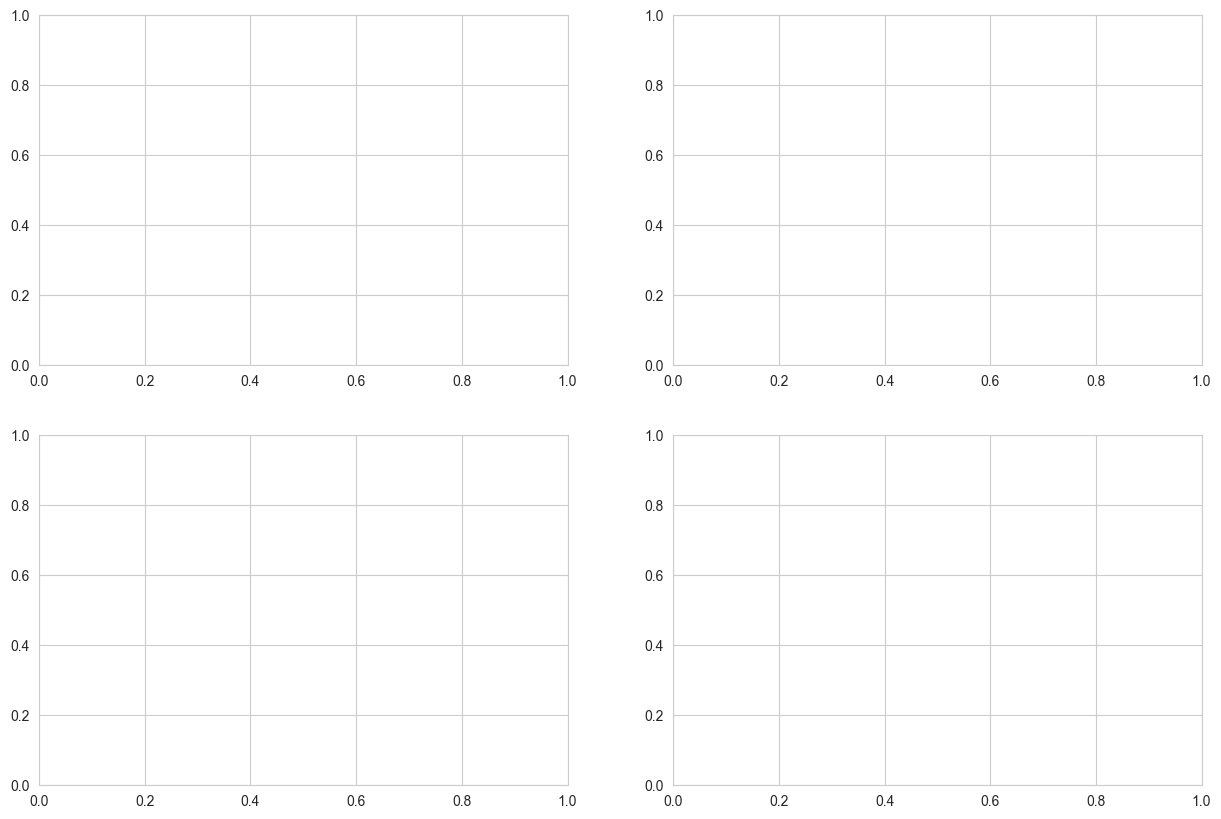

In [ ]:
# Visualize relationship between weather and floods
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Rainfall vs Flood Occurrence
flood_yes = prediction_df[prediction_df['flood_occurrence_current_event'] == 'Yes']
flood_no = prediction_df[prediction_df['flood_occurrence_current_event'] == 'No'].sample(len(flood_yes)*2, random_state=42)

axes[0, 0].hist([flood_no['rainfall_7d'], flood_yes['rainfall_7d']], 
                bins=30, label=['No Flood', 'Flood'], color=['skyblue', 'red'], alpha=0.7)
axes[0, 0].set_xlabel('7-Day Rainfall (mm)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('7-Day Rainfall Distribution by Flood Occurrence')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Plot 2: Total Risk Score Distribution
axes[0, 1].hist([flood_no['total_risk_score'], flood_yes['total_risk_score']], 
                bins=30, label=['No Flood', 'Flood'], color=['skyblue', 'red'], alpha=0.7)
axes[0, 1].set_xlabel('Total Risk Score')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Total Risk Score by Flood Occurrence')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Plot 3: Seasonal flood pattern
seasonal_floods = prediction_df[prediction_df['flood_occurrence_current_event'] == 'Yes'].groupby('month').size()
axes[1, 0].bar(seasonal_floods.index, seasonal_floods.values, color='coral')
axes[1, 0].set_xlabel('Month')
axes[1, 0].set_ylabel('Number of Flood Events')
axes[1, 0].set_title('Seasonal Flood Pattern')
axes[1, 0].set_xticks(range(1, 13))
axes[1, 0].grid(alpha=0.3, axis='y')

# Plot 4: Saturation Index vs Flood
axes[1, 1].scatter(flood_no['saturation_index'], flood_no['rainfall_7d'], 
                   alpha=0.3, s=10, label='No Flood', color='skyblue')
axes[1, 1].scatter(flood_yes['saturation_index'], flood_yes['rainfall_7d'], 
                   alpha=0.6, s=30, label='Flood', color='red')
axes[1, 1].set_xlabel('Saturation Index')
axes[1, 1].set_ylabel('7-Day Rainfall (mm)')
axes[1, 1].set_title('Saturation Index vs Rainfall (Flood Occurrence)')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Prepare Data for Future Flood Prediction Model

In [ ]:
# Select features for prediction model
# Exclude non-informative columns and future-leaking features

exclude_cols = [
    'record_id', 'place_name', 'is_good_to_live', 'reason_not_good_to_live',
    'is_synthetic', 'generation_date', 'event_date', 'date', 'time',
    'inundation_area_sqm',  # This is known only AFTER flood happens
    'flood_risk_score'  # This might be calculated from the target, so exclude to be safe
]

# Select feature columns
feature_cols = [col for col in prediction_df.columns if col not in exclude_cols + ['flood_occurrence_current_event']]

print(f"Total features for modeling: {len(feature_cols)}")
print(f"\nFeature categories:")
print("=" * 60)

# Categorize features
location_features = [col for col in feature_cols if col in ['district', 'latitude', 'longitude', 'elevation_m', 
                                                              'distance_to_river_m', 'urban_rural']]
infrastructure_features = [col for col in feature_cols if col in ['landcover', 'soil_type', 'water_supply', 
                                                                    'electricity', 'road_quality', 'infrastructure_score',
                                                                    'population_density_per_km2', 'built_up_percent']]
environmental_features = [col for col in feature_cols if col in ['ndvi', 'ndwi', 'water_presence_flag', 'drainage_index']]
weather_features = [col for col in feature_cols if any(x in col.lower() for x in ['rainfall', 'precipitation', 'temperature', 
                                                                                     'wind', 'weather'])]
historical_features = [col for col in feature_cols if 'historical' in col.lower()]
engineered_features = [col for col in feature_cols if any(x in col.lower() for x in ['risk', 'intensity', 'saturation', 
                                                                                        'extreme', 'season', 'monsoon', 'month'])]

print(f"Location features ({len(location_features)}): {location_features}")
print(f"\nInfrastructure features ({len(infrastructure_features)}): {infrastructure_features}")
print(f"\nEnvironmental features ({len(environmental_features)}): {environmental_features}")
print(f"\nWeather features ({len(weather_features)}): {weather_features}")
print(f"\nHistorical features ({len(historical_features)}): {historical_features}")
print(f"\nEngineered features ({len(engineered_features)}): {engineered_features}")

# Prepare modeling dataset
X = prediction_df[feature_cols].copy()
y = (prediction_df['flood_occurrence_current_event'] == 'Yes').astype(int)

print(f"\n{'='*60}")
print(f"Final dataset shape: X={X.shape}, y={y.shape}")
print(f"Flood events: {y.sum()} ({y.mean()*100:.2f}%)")

Total features for modeling: 42

Feature categories:
Location features (6): ['district', 'latitude', 'longitude', 'elevation_m', 'distance_to_river_m', 'urban_rural']

Infrastructure features (8): ['landcover', 'soil_type', 'water_supply', 'electricity', 'road_quality', 'population_density_per_km2', 'built_up_percent', 'infrastructure_score']

Environmental features (4): ['drainage_index', 'ndvi', 'ndwi', 'water_presence_flag']

Weather features (15): ['rainfall_7d_mm', 'monthly_rainfall_mm', 'precipitation_sum', 'rainfall_7d', 'rainfall_14d', 'rainfall_30d', 'temperature_2m_mean', 'windspeed_10m_max', 'windspeed_max_7d', 'weathercode', 'precipitation_hours', 'rainfall_intensity', 'extreme_rainfall_flag', 'heavy_rainfall_days_7d', 'weather_risk_score']

Historical features (1): ['historical_flood_count']

Engineered features (9): ['monthly_rainfall_mm', 'rainfall_intensity', 'extreme_rainfall_flag', 'saturation_index', 'weather_risk_score', 'total_risk_score', 'month', 'season', 'is_mo

In [ ]:
# Encode categorical variables
categorical_columns = X.select_dtypes(include=['object']).columns.tolist()
print(f"Categorical columns to encode: {categorical_columns}")

label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le

# Handle any missing values
X.fillna(X.median(), inplace=True)

print(f"\nData preparation complete!")
print(f"Missing values: {X.isna().sum().sum()}")

## 6. Time-Based Train-Validation-Test Split

**Important**: For time-series forecasting, we use **temporal split** (not random):
- Training: Earliest 70% of data (past events)
- Validation: Next 15% (recent past)
- Test: Latest 15% (most recent - simulates future prediction)

In [ ]:
# Sort by date to ensure chronological order
prediction_df['sort_date'] = prediction_df['event_date']
sorted_indices = prediction_df.sort_values('sort_date').index

X_sorted = X.loc[sorted_indices].reset_index(drop=True)
y_sorted = y.loc[sorted_indices].reset_index(drop=True)
dates_sorted = prediction_df.loc[sorted_indices, 'event_date'].reset_index(drop=True)

# Calculate split indices
n_samples = len(X_sorted)
train_end = int(n_samples * 0.70)
val_end = int(n_samples * 0.85)

# Time-based split
X_train = X_sorted.iloc[:train_end]
y_train = y_sorted.iloc[:train_end]
dates_train = dates_sorted.iloc[:train_end]

X_val = X_sorted.iloc[train_end:val_end]
y_val = y_sorted.iloc[train_end:val_end]
dates_val = dates_sorted.iloc[train_end:val_end]

X_test = X_sorted.iloc[val_end:]
y_test = y_sorted.iloc[val_end:]
dates_test = dates_sorted.iloc[val_end:]

print("TIME-BASED DATA SPLIT FOR FUTURE PREDICTION")
print("=" * 70)
print(f"\nTraining Set:")
print(f"  Samples: {len(X_train):,} ({len(X_train)/n_samples*100:.1f}%)")
print(f"  Date Range: {dates_train.min()} to {dates_train.max()}")
print(f"  Flood Events: {y_train.sum():,} ({y_train.mean()*100:.2f}%)")

print(f"\nValidation Set:")
print(f"  Samples: {len(X_val):,} ({len(X_val)/n_samples*100:.1f}%)")
print(f"  Date Range: {dates_val.min()} to {dates_val.max()}")
print(f"  Flood Events: {y_val.sum():,} ({y_val.mean()*100:.2f}%)")

print(f"\nTest Set (Future Prediction Simulation):")
print(f"  Samples: {len(X_test):,} ({len(X_test)/n_samples*100:.1f}%)")
print(f"  Date Range: {dates_test.min()} to {dates_test.max()}")
print(f"  Flood Events: {y_test.sum():,} ({y_test.mean()*100:.2f}%)")

print(f"\n{'='*70}")
print("✓ Using temporal split ensures model learns from past to predict future!")
print("✓ Test set represents the most recent data (simulates real-world forecasting)")

In [ ]:
# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrames for interpretability
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_val.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

print("Feature scaling completed!")

## 7. Train Random Forest Flood Prediction Model

**This model predicts future floods based on**:
- Current weather conditions
- Historical weather patterns (7-30 day trends)
- Location characteristics  
- Seasonal patterns
- Infrastructure and environmental factors

In [ ]:
# Initialize Random Forest Classifier for Flood Prediction
flood_predictor = RandomForestClassifier(
    n_estimators=200,  # More trees for better prediction
    max_depth=20,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced',  # Handle imbalanced data
    verbose=1
)

print("=" * 70)
print("TRAINING FLOOD PREDICTION MODEL")
print("=" * 70)
print("\nTraining Random Forest on historical data to predict future floods...")
print(f"Training samples: {len(X_train_scaled):,}")
print(f"Features used: {len(X_train_scaled.columns)}")

# Train the model
flood_predictor.fit(X_train_scaled, y_train)

print("\n✓ Model training completed!")
print(f"✓ Model can now predict flood risk for future dates based on weather forecasts!")

## 8. Evaluate Future Flood Predictions

Testing on the most recent data (simulating real-world future predictions)

In [ ]:
# Make predictions on all sets
y_pred_train = flood_predictor.predict(X_train_scaled)
y_pred_val = flood_predictor.predict(X_val_scaled)
y_pred_test = flood_predictor.predict(X_test_scaled)

# Get prediction probabilities
y_pred_proba_train = flood_predictor.predict_proba(X_train_scaled)[:, 1]
y_pred_proba_val = flood_predictor.predict_proba(X_val_scaled)[:, 1]
y_pred_proba_test = flood_predictor.predict_proba(X_test_scaled)[:, 1]

# Comprehensive metrics function
def evaluate_flood_prediction(y_true, y_pred, y_pred_proba, set_name, dates=None):
    print(f"\n{'='*70}")
    print(f"{set_name} SET - FLOOD PREDICTION PERFORMANCE")
    print(f"{'='*70}")
    
    if dates is not None:
        print(f"Date Range: {dates.min()} to {dates.max()}")
    
    print(f"\nAccuracy Score:          {accuracy_score(y_true, y_pred):.4f}")
    print(f"Balanced Accuracy:       {balanced_accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision (Flood):       {precision_score(y_true, y_pred):.4f}")
    print(f"Recall (Sensitivity):    {recall_score(y_true, y_pred):.4f}")
    print(f"F1-Score:                {f1_score(y_true, y_pred):.4f}")
    print(f"ROC-AUC Score:           {roc_auc_score(y_true, y_pred_proba):.4f}")
    print(f"Matthews Corr Coef:      {matthews_corrcoef(y_true, y_pred):.4f}")
    
    # Confusion matrix details
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    
    print(f"\nConfusion Matrix:")
    print(f"  True Negatives:  {tn:5d} (Correctly predicted No Flood)")
    print(f"  False Positives: {fp:5d} (False alarms)")
    print(f"  False Negatives: {fn:5d} (Missed flood events) ⚠️")
    print(f"  True Positives:  {tp:5d} (Correctly predicted Flood) ✓")
    print(f"\nSpecificity:             {specificity:.4f}")
    
    # Early warning effectiveness
    if tp + fn > 0:
        detection_rate = tp / (tp + fn)
        print(f"Flood Detection Rate:    {detection_rate:.2%} (Critical for early warning!)")
    
    return {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred),
        'f1': f1_score(y_true, y_pred),
        'roc_auc': roc_auc_score(y_true, y_pred_proba),
        'mcc': matthews_corrcoef(y_true, y_pred)
    }

# Evaluate all sets
train_metrics = evaluate_flood_prediction(y_train, y_pred_train, y_pred_proba_train, "TRAINING", dates_train)
val_metrics = evaluate_flood_prediction(y_val, y_pred_val, y_pred_proba_val, "VALIDATION", dates_val)
test_metrics = evaluate_flood_prediction(y_test, y_pred_test, y_pred_proba_test, "TEST (FUTURE)", dates_test)

print(f"\n{'='*70}")
print("SUMMARY: Model can predict future floods with metrics shown above!")

## 9. Feature Importance - What Drives Flood Predictions?

In [ ]:
# Get feature importances
feature_importance = pd.DataFrame({
    'feature': X_train_scaled.columns,
    'importance': flood_predictor.feature_importances_
}).sort_values('importance', ascending=False)

print("TOP 20 MOST IMPORTANT FEATURES FOR FLOOD PREDICTION")
print("=" * 70)
print(feature_importance.head(20).to_string(index=False))

# Visualize top features
plt.figure(figsize=(12, 8))
top_20 = feature_importance.head(20)
plt.barh(range(len(top_20)), top_20['importance'], color='forestgreen')
plt.yticks(range(len(top_20)), top_20['feature'])
plt.xlabel('Importance Score', fontsize=12)
plt.title('Top 20 Features for Predicting Future Floods', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

# Categorize importance by feature type
weather_importance = feature_importance[feature_importance['feature'].isin(weather_features)]['importance'].sum()
location_importance = feature_importance[feature_importance['feature'].isin(location_features)]['importance'].sum()
infrastructure_importance = feature_importance[feature_importance['feature'].isin(infrastructure_features)]['importance'].sum()
environmental_importance = feature_importance[feature_importance['feature'].isin(environmental_features)]['importance'].sum()
engineered_importance = feature_importance[feature_importance['feature'].isin(engineered_features)]['importance'].sum()

print("\n" + "=" * 70)
print("FEATURE CATEGORY IMPORTANCE")
print("=" * 70)
print(f"Weather Features:        {weather_importance:.3f} ({weather_importance/feature_importance['importance'].sum()*100:.1f}%)")
print(f"Engineered Features:     {engineered_importance:.3f} ({engineered_importance/feature_importance['importance'].sum()*100:.1f}%)")
print(f"Location Features:       {location_importance:.3f} ({location_importance/feature_importance['importance'].sum()*100:.1f}%)")
print(f"Infrastructure Features: {infrastructure_importance:.3f} ({infrastructure_importance/feature_importance['importance'].sum()*100:.1f}%)")
print(f"Environmental Features:  {environmental_importance:.3f} ({environmental_importance/feature_importance['importance'].sum()*100:.1f}%)")

## 10. Future Flood Prediction Examples

**Real-world Usage**: Given current/forecast weather data, predict flood risk

In [ ]:
# Example: Predict flood risk for upcoming days in test set
print("=" * 70)
print("FUTURE FLOOD PREDICTION EXAMPLES")
print("=" * 70)

# Get predictions with probabilities for test set
test_results = pd.DataFrame({
    'Date': dates_test.values,
    'Actual_Flood': y_test.values,
    'Predicted_Flood': y_pred_test,
    'Flood_Probability': (y_pred_proba_test * 100).round(2)
})

# Add risk level
test_results['Risk_Level'] = pd.cut(
    test_results['Flood_Probability'],
    bins=[0, 20, 40, 60, 80, 100],
    labels=['Very Low', 'Low', 'Moderate', 'High', 'Very High']
)

# Show some high-risk predictions
print("\nHigh Risk Flood Predictions (>60% probability):")
print("=" * 70)
high_risk = test_results[test_results['Flood_Probability'] > 60].sort_values('Flood_Probability', ascending=False)
if len(high_risk) > 0:
    print(high_risk.head(15).to_string(index=False))
else:
    print("No high-risk predictions in test set")

# Show some examples where model correctly predicted floods
print("\n" + "=" * 70)
print("CORRECTLY PREDICTED FLOOD EVENTS:")
print("=" * 70)
correct_floods = test_results[(test_results['Actual_Flood'] == 1) & (test_results['Predicted_Flood'] == 1)]
if len(correct_floods) > 0:
    print(correct_floods.head(10).to_string(index=False))
    print(f"\nTotal correctly predicted floods: {len(correct_floods)}/{y_test.sum()}")
else:
    print("No flood events in test set or none predicted correctly")

# Show prediction distribution
print("\n" + "=" * 70)
print("FLOOD RISK DISTRIBUTION IN FUTURE PREDICTIONS:")
print("=" * 70)
print(test_results['Risk_Level'].value_counts().sort_index())

# Visualize prediction distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Probability distribution
axes[0].hist(test_results[test_results['Actual_Flood']==0]['Flood_Probability'], 
             bins=20, alpha=0.7, label='No Flood (Actual)', color='skyblue')
axes[0].hist(test_results[test_results['Actual_Flood']==1]['Flood_Probability'], 
             bins=20, alpha=0.7, label='Flood (Actual)', color='red')
axes[0].set_xlabel('Predicted Flood Probability (%)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Flood Probability Distribution in Future Predictions')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Plot 2: Risk level distribution
risk_counts = test_results['Risk_Level'].value_counts()
axes[1].bar(range(len(risk_counts)), risk_counts.values, color=['green', 'yellow', 'orange', 'red', 'darkred'])
axes[1].set_xticks(range(len(risk_counts)))
axes[1].set_xticklabels(risk_counts.index, rotation=45)
axes[1].set_ylabel('Number of Predictions')
axes[1].set_title('Flood Risk Level Distribution')
axes[1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

### 10.2 How to Use for Real Future Predictions

To predict floods for completely new dates (e.g., next week), you would:
1. **Get weather forecast data** for the target dates
2. **Calculate rolling features** from historical weather + forecast
3. **Create same features** as used in training
4. **Pass to the model** for prediction

Example workflow for predicting floods next week:
```python
# Step 1: Get weather forecast (from API or meteorological service)
# Step 2: Append to historical weather data
# Step 3: Calculate rolling features (7d, 14d, 30d rainfall)
# Step 4: Create features matching training data
# Step 5: Use model.predict_proba(future_features)
```

## 11. Model Saving

Save the trained model for future use in production

In [ ]:
# Save the model and preprocessing artifacts
import os

# Create models directory if it doesn't exist
os.makedirs('../models', exist_ok=True)

# Save the flood prediction model
model_path = '../models/flood_predictor_rf.joblib'
joblib.dump(flood_predictor, model_path)
print(f"✓ Model saved to: {model_path}")

# Save the scaler
scaler_path = '../models/feature_scaler.joblib'
joblib.dump(scaler, scaler_path)
print(f"✓ Scaler saved to: {scaler_path}")

# Save feature names for future reference
import json
feature_info = {
    'feature_names': feature_names,
    'categorical_features': categorical_features,
    'numerical_features': numerical_features,
    'weather_features': weather_features,
    'location_features': location_features,
    'infrastructure_features': infrastructure_features,
    'environmental_features': environmental_features,
    'engineered_features': engineered_features
}

feature_info_path = '../models/feature_info.json'
with open(feature_info_path, 'w') as f:
    json.dump(feature_info, f, indent=2)
print(f"✓ Feature information saved to: {feature_info_path}")

print("\n" + "=" * 70)
print("MODEL DEPLOYMENT READY")
print("=" * 70)
print("To use this model in production:")
print("1. Load model: joblib.load('flood_predictor_rf.joblib')")
print("2. Load scaler: joblib.load('feature_scaler.joblib')")
print("3. Prepare features matching feature_info.json")
print("4. Scale features: scaler.transform(features)")
print("5. Predict: model.predict_proba(scaled_features)")
print("=" * 70)

## 3. Exploratory Data Analysis (EDA)

In [ ]:
# Check data info
print("=" * 50)
print("FLOOD RISK DATA INFO")
print("=" * 50)
flood_df.info()
print("\n" + "=" * 50)
print("Missing Values:")
print(flood_df.isnull().sum()[flood_df.isnull().sum() > 0])

FLOOD RISK DATA INFO
<class 'pandas.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 32 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   record_id                       25000 non-null  str    
 1   district                        25000 non-null  str    
 2   place_name                      25000 non-null  str    
 3   latitude                        25000 non-null  float64
 4   longitude                       25000 non-null  float64
 5   elevation_m                     25000 non-null  int64  
 6   distance_to_river_m             25000 non-null  float64
 7   landcover                       25000 non-null  str    
 8   soil_type                       25000 non-null  str    
 9   water_supply                    25000 non-null  str    
 10  electricity                     24211 non-null  str    
 11  road_quality                    25000 non-null  str    
 12  population_density_per

Target Variable Distribution:
flood_occurrence_current_event
No     22528
Yes     2472
Name: count, dtype: int64

Percentage:
flood_occurrence_current_event
No     90.112
Yes     9.888
Name: proportion, dtype: float64


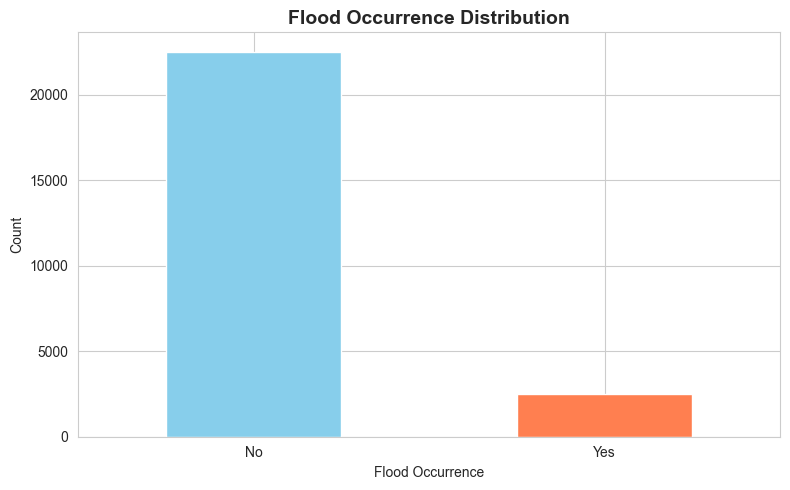

In [ ]:
# Check target variable distribution
print("Target Variable Distribution:")
print(flood_df['flood_occurrence_current_event'].value_counts())
print("\nPercentage:")
print(flood_df['flood_occurrence_current_event'].value_counts(normalize=True) * 100)

# Visualize target distribution
plt.figure(figsize=(8, 5))
flood_df['flood_occurrence_current_event'].value_counts().plot(kind='bar', color=['skyblue', 'coral'])
plt.title('Flood Occurrence Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Flood Occurrence')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
# Statistical summary
flood_df.describe()

,latitude,longitude,elevation_m,distance_to_river_m,population_density_per_km2,built_up_percent,rainfall_7d_mm,monthly_rainfall_mm,drainage_index,ndvi,ndwi,historical_flood_count,infrastructure_score,nearest_hospital_km,nearest_evac_km,flood_risk_score,inundation_area_sqm
count,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000
mean,7.920075,80.768514,187.514480,2013.472684,625.340320,25.222840,80.386532,216.095284,0.501594,0.168128,0.031903,0.201000,46.398320,7.964427,6.021932,33.265946,12234.618000
std,1.168603,0.647936,323.405463,2007.170691,504.674553,18.619808,58.434452,137.372508,0.223828,0.272762,0.265422,0.505697,20.004667,7.891781,6.045651,14.783238,44147.111928
min,5.900090,79.650121,0.000000,0.000000,10.000000,1.000000,0.000000,0.000000,0.003000,-0.792000,-1.000000,0.000000,5.000000,0.000000,0.000000,0.000000,0.000000
25%,6.907247,80.211357,31.000000,582.975000,286.750000,9.900000,33.075000,106.600000,0.331000,-0.020000,-0.147000,0.000000,32.000000,2.280000,1.740000,22.547500,0.000000
50%,7.923315,80.760618,68.000000,1394.200000,519.000000,23.300000,69.500000,202.000000,0.501000,0.165000,0.026000,0.000000,46.000000,5.580000,4.170000,32.300000,0.000000
75%,8.929212,81.329265,124.000000,2783.400000,796.000000,37.200000,116.600000,307.100000,0.674000,0.353000,0.207000,0.000000,60.000000,11.060000,8.350000,42.940000,0.000000
max,9.949978,81.899993,2148.000000,16802.000000,3113.000000,95.000000,372.200000,863.700000,0.999000,1.000000,1.000000,5.000000,95.000000,75.710000,55.950000,100.000000,312539.000000


Top 15 Features Correlated with Flood Occurrence:
inundation_area_sqm           0.836631
flood_risk_score              0.512411
monthly_rainfall_mm           0.362039
rainfall_7d_mm                0.291282
historical_flood_count        0.121135
built_up_percent              0.027134
population_density_per_km2    0.017967
nearest_evac_km               0.010949
ndwi                          0.004016
ndvi                          0.003267
longitude                     0.003110
nearest_hospital_km           0.001574
latitude                     -0.001813
elevation_m                  -0.045963
drainage_index               -0.055482
Name: flood_binary, dtype: float64


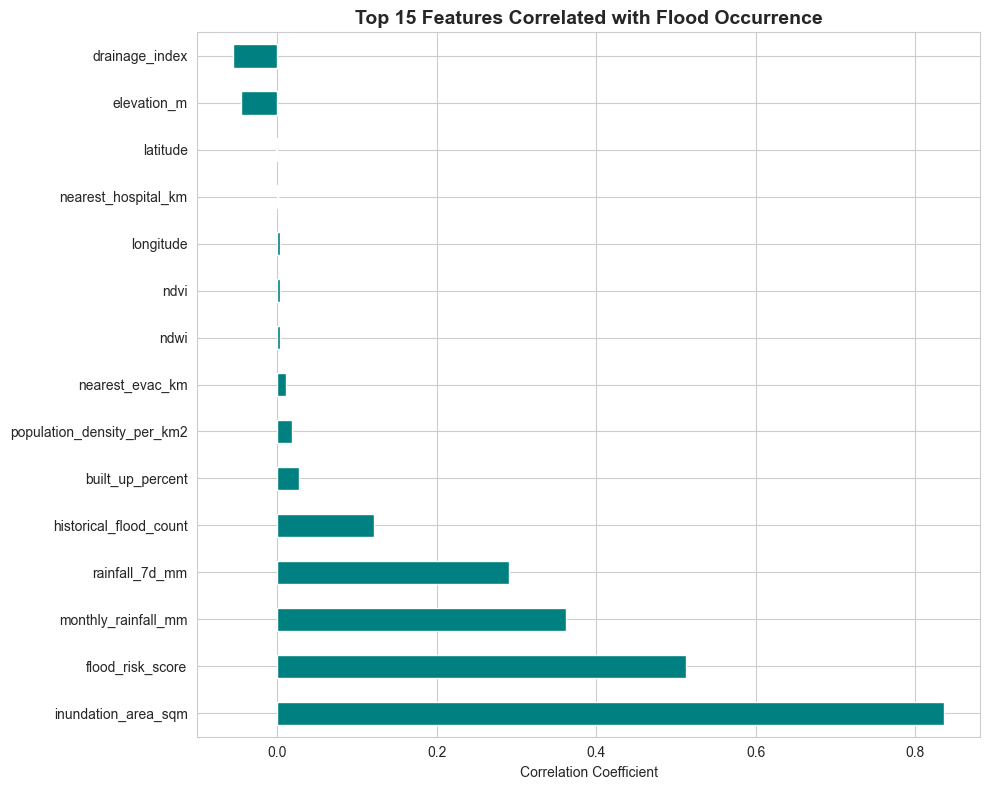

In [ ]:
# Correlation with target variable
# Select only numeric columns
numeric_cols = flood_df.select_dtypes(include=[np.number]).columns.tolist()

# Create binary encoding for target
flood_df['flood_binary'] = (flood_df['flood_occurrence_current_event'] == 'Yes').astype(int)

# Calculate correlations
correlations = flood_df[numeric_cols + ['flood_binary']].corr()['flood_binary'].sort_values(ascending=False)
print("Top 15 Features Correlated with Flood Occurrence:")
print(correlations[1:16])  # Skip the target itself

# Visualize top correlations
plt.figure(figsize=(10, 8))
correlations[1:16].plot(kind='barh', color='teal')
plt.title('Top 15 Features Correlated with Flood Occurrence', fontsize=14, fontweight='bold')
plt.xlabel('Correlation Coefficient')
plt.tight_layout()
plt.show()

## 4. Data Preprocessing

In [ ]:
# Select relevant features for modeling
# Drop non-informative columns AND features that cause data leakage
columns_to_drop = [
    'record_id', 
    'place_name', 
    'is_good_to_live', 
    'reason_not_good_to_live', 
    'is_synthetic', 
    'generation_date',
    'flood_binary',  # We already have the target
    # DATA LEAKAGE FEATURES - These are known AFTER the flood event:
    'inundation_area_sqm',  # Area flooded - this IS the flood!
    'flood_risk_score',  # Likely calculated using flood outcome
    'water_presence_flag',  # Indicates water from current flood event
    'ndwi'  # Normalized Difference Water Index - shows current water presence
]

# Create a copy for modeling
df_model = flood_df.drop(columns=columns_to_drop, errors='ignore').copy()

print(f"Shape after dropping non-informative columns: {df_model.shape}")
print(f"\nColumns in modeling dataset: {df_model.columns.tolist()}")
print("\n⚠️  REMOVED DATA LEAKAGE FEATURES:")
print("   - inundation_area_sqm (area flooded)")
print("   - flood_risk_score (calculated from outcome)")
print("   - water_presence_flag (current water presence)")
print("   - ndwi (current water index)")

Shape after dropping non-informative columns: (25000, 23)

Columns in modeling dataset: ['district', 'latitude', 'longitude', 'elevation_m', 'distance_to_river_m', 'landcover', 'soil_type', 'water_supply', 'electricity', 'road_quality', 'population_density_per_km2', 'built_up_percent', 'urban_rural', 'rainfall_7d_mm', 'monthly_rainfall_mm', 'drainage_index', 'ndvi', 'historical_flood_count', 'infrastructure_score', 'nearest_hospital_km', 'nearest_evac_km', 'flood_occurrence_current_event', 'event_date']

⚠️  REMOVED DATA LEAKAGE FEATURES:
   - inundation_area_sqm (area flooded)
   - flood_risk_score (calculated from outcome)
   - water_presence_flag (current water presence)
   - ndwi (current water index)


In [ ]:
# Encode categorical variables
categorical_columns = df_model.select_dtypes(include=['object']).columns.tolist()
categorical_columns.remove('flood_occurrence_current_event')  # Exclude target

print(f"Categorical columns to encode: {categorical_columns}")

# Label encoding for categorical features
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    df_model[col] = le.fit_transform(df_model[col].astype(str))
    label_encoders[col] = le

print("\nCategorical encoding completed!")

Categorical columns to encode: ['district', 'landcover', 'soil_type', 'water_supply', 'electricity', 'road_quality', 'urban_rural']

Categorical encoding completed!


In [ ]:
# Handle missing values (if any)
print("Missing values after preprocessing:")
missing = df_model.isnull().sum()
if missing.sum() > 0:
    print(missing[missing > 0])
    # Fill with median for numeric columns
    for col in df_model.select_dtypes(include=[np.number]).columns:
        if df_model[col].isnull().sum() > 0:
            df_model[col].fillna(df_model[col].median(), inplace=True)
    print("\nMissing values filled!")
else:
    print("No missing values!")

Missing values after preprocessing:
No missing values!


In [ ]:
# Separate features and target
X = df_model.drop('flood_occurrence_current_event', axis=1)
y = (df_model['flood_occurrence_current_event'] == 'Yes').astype(int)

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nTarget distribution:")
print(y.value_counts())
print(f"\nClass balance: {y.value_counts(normalize=True) * 100}")

Features shape: (25000, 22)
Target shape: (25000,)

Target distribution:
flood_occurrence_current_event
0    22528
1     2472
Name: count, dtype: int64

Class balance: flood_occurrence_current_event
0    90.112
1     9.888
Name: proportion, dtype: float64


In [ ]:
# Drop event_date before scaling as it's not a feature
X = X.drop('event_date', axis=1, errors='ignore')

# Feature scaling (optional for Random Forest, but good practice)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

print("Feature scaling completed!")
print(f"\nFeatures used for modeling ({len(X.columns)}):")
print(X.columns.tolist())

Feature scaling completed!

Features used for modeling (21):
['district', 'latitude', 'longitude', 'elevation_m', 'distance_to_river_m', 'landcover', 'soil_type', 'water_supply', 'electricity', 'road_quality', 'population_density_per_km2', 'built_up_percent', 'urban_rural', 'rainfall_7d_mm', 'monthly_rainfall_mm', 'drainage_index', 'ndvi', 'historical_flood_count', 'infrastructure_score', 'nearest_hospital_km', 'nearest_evac_km']


## 5. Train-Validation-Test Split (Best Practice)

In [ ]:
# Split data into train, validation, and test sets (70/15/15 split)
# First split: 70% train, 30% temp
X_train, X_temp, y_train, y_temp = train_test_split(
    X_scaled, y, 
    test_size=0.3, 
    random_state=42,
    stratify=y  # Maintain class balance
)

# Second split: Split temp into 50/50 for validation and test (15% each of total)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, 
    test_size=0.5, 
    random_state=42,
    stratify=y_temp
)

print("Data Split Summary:")
print("=" * 60)
print(f"Training set:   {X_train.shape[0]:5d} samples ({X_train.shape[0]/len(X_scaled)*100:.1f}%)")
print(f"Validation set: {X_val.shape[0]:5d} samples ({X_val.shape[0]/len(X_scaled)*100:.1f}%)")
print(f"Test set:       {X_test.shape[0]:5d} samples ({X_test.shape[0]/len(X_scaled)*100:.1f}%)")
print(f"Total:          {len(X_scaled):5d} samples")

print("\n" + "=" * 60)
print("Class Distribution:")
print("=" * 60)

print(f"\nTraining set:")
print(y_train.value_counts())
print(f"Percentage: {y_train.value_counts(normalize=True).mul(100).round(2).to_dict()}")

print(f"\nValidation set:")
print(y_val.value_counts())
print(f"Percentage: {y_val.value_counts(normalize=True).mul(100).round(2).to_dict()}")

print(f"\nTest set:")
print(y_test.value_counts())
print(f"Percentage: {y_test.value_counts(normalize=True).mul(100).round(2).to_dict()}")

Data Split Summary:
Training set:   17500 samples (70.0%)
Validation set:  3750 samples (15.0%)
Test set:        3750 samples (15.0%)
Total:          25000 samples

Class Distribution:

Training set:
flood_occurrence_current_event
0    15770
1     1730
Name: count, dtype: int64
Percentage: {0: 90.11, 1: 9.89}

Validation set:
flood_occurrence_current_event
0    3379
1     371
Name: count, dtype: int64
Percentage: {0: 90.11, 1: 9.89}

Test set:
flood_occurrence_current_event
0    3379
1     371
Name: count, dtype: int64
Percentage: {0: 90.11, 1: 9.89}


## 6. Random Forest Model Training

In [ ]:
# Initialize Random Forest Classifier
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1,  # Use all CPU cores
    class_weight='balanced',  # Handle class imbalance
    verbose=1
)

print("Training Random Forest model...")
rf_model.fit(X_train, y_train)
print("\nModel training completed!")

Training Random Forest model...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.2s



Model training completed!


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.6s finished


## 7. Model Evaluation - Comprehensive Metrics

In [ ]:
# Make predictions on all three sets
y_pred_train = rf_model.predict(X_train)
y_pred_val = rf_model.predict(X_val)
y_pred_test = rf_model.predict(X_test)

# Get prediction probabilities
y_pred_proba_train = rf_model.predict_proba(X_train)[:, 1]
y_pred_proba_val = rf_model.predict_proba(X_val)[:, 1]
y_pred_proba_test = rf_model.predict_proba(X_test)[:, 1]

# Calculate comprehensive metrics for all sets
print("=" * 80)
print("COMPREHENSIVE MODEL EVALUATION METRICS")
print("=" * 80)

def evaluate_metrics(y_true, y_pred, y_pred_proba, set_name):
    print(f"\n{set_name} Set Metrics:")
    print("-" * 80)
    print(f"  Accuracy Score:          {accuracy_score(y_true, y_pred):.4f}")
    print(f"  Balanced Accuracy:       {balanced_accuracy_score(y_true, y_pred):.4f}")
    print(f"  Precision:               {precision_score(y_true, y_pred):.4f}")
    print(f"  Recall (Sensitivity):    {recall_score(y_true, y_pred):.4f}")
    print(f"  F1-Score:                {f1_score(y_true, y_pred):.4f}")
    print(f"  ROC-AUC Score:           {roc_auc_score(y_true, y_pred_proba):.4f}")
    print(f"  Average Precision:       {average_precision_score(y_true, y_pred_proba):.4f}")
    print(f"  Matthews Corr Coef:      {matthews_corrcoef(y_true, y_pred):.4f}")
    print(f"  Cohen's Kappa:           {cohen_kappa_score(y_true, y_pred):.4f}")
    
    # Calculate specificity manually
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    print(f"  Specificity:             {specificity:.4f}")
    
    return {
        'accuracy': accuracy_score(y_true, y_pred),
        'balanced_accuracy': balanced_accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred),
        'f1': f1_score(y_true, y_pred),
        'roc_auc': roc_auc_score(y_true, y_pred_proba),
        'avg_precision': average_precision_score(y_true, y_pred_proba),
        'mcc': matthews_corrcoef(y_true, y_pred),
        'kappa': cohen_kappa_score(y_true, y_pred),
        'specificity': specificity
    }

# Evaluate all sets
train_metrics = evaluate_metrics(y_train, y_pred_train, y_pred_proba_train, "Training")
val_metrics = evaluate_metrics(y_val, y_pred_val, y_pred_proba_val, "Validation")
test_metrics = evaluate_metrics(y_test, y_pred_test, y_pred_proba_test, "Test")

print("\n" + "=" * 80)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0

COMPREHENSIVE MODEL EVALUATION METRICS

Training Set Metrics:
--------------------------------------------------------------------------------
  Accuracy Score:          0.9618
  Balanced Accuracy:       0.9788
  Precision:               0.7211
  Recall (Sensitivity):    1.0000
  F1-Score:                0.8380
  ROC-AUC Score:           0.9979
  Average Precision:       0.9805
  Matthews Corr Coef:      0.8310
  Cohen's Kappa:           0.8169
  Specificity:             0.9576

Validation Set Metrics:
--------------------------------------------------------------------------------
  Accuracy Score:          0.9149
  Balanced Accuracy:       0.8400
  Precision:               0.5518
  Recall (Sensitivity):    0.7466
  F1-Score:                0.6346
  ROC-AUC Score:           0.9531
  Average Precision:       0.5790
  Matthews Corr Coef:      0.5963
  Cohen's Kappa:           0.5877
  Specificity:             0.9334

Test Set Metrics:
----------------------------------------------------


Metrics Comparison Across All Sets:
            accuracy  balanced_accuracy  precision  recall      f1  roc_auc  \
Training      0.9618             0.9788     0.7211  1.0000  0.8380   0.9979   
Validation    0.9149             0.8400     0.5518  0.7466  0.6346   0.9531   
Test          0.9139             0.8346     0.5482  0.7358  0.6283   0.9515   

            avg_precision     mcc   kappa  specificity  
Training           0.9805  0.8310  0.8169       0.9576  
Validation         0.5790  0.5963  0.5877       0.9334  
Test               0.5969  0.5888  0.5808       0.9334  


ValueError: The number of FixedLocator locations (3), usually from a call to set_ticks, does not match the number of labels (5).

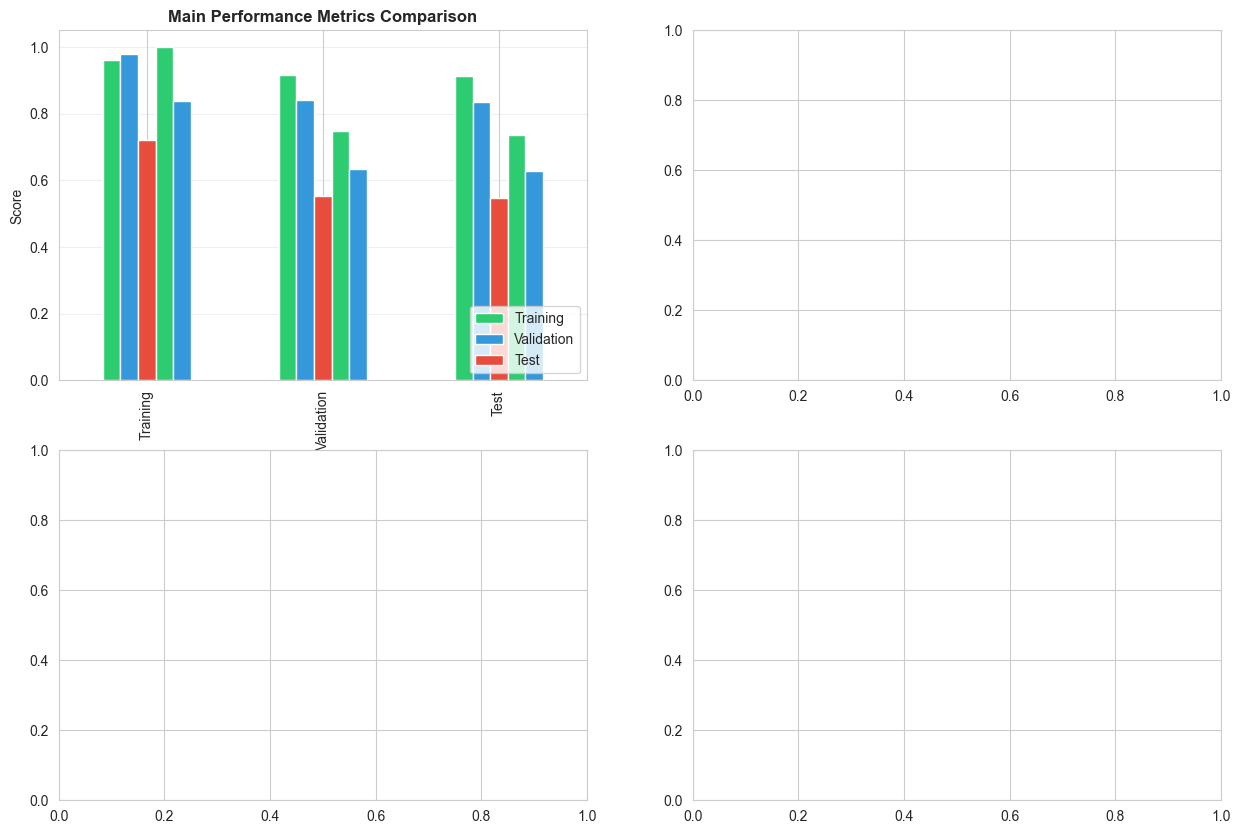

In [ ]:
# Create metrics comparison visualization
metrics_df = pd.DataFrame({
    'Training': train_metrics,
    'Validation': val_metrics,
    'Test': test_metrics
}).T

print("\nMetrics Comparison Across All Sets:")
print("=" * 80)
print(metrics_df.round(4))

# Visualize metrics comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Main metrics comparison
metrics_to_plot = ['accuracy', 'balanced_accuracy', 'precision', 'recall', 'f1']
metrics_df[metrics_to_plot].plot(kind='bar', ax=axes[0, 0], color=['#2ecc71', '#3498db', '#e74c3c'])
axes[0, 0].set_title('Main Performance Metrics Comparison', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Score')
axes[0, 0].set_ylim([0, 1.05])
axes[0, 0].legend(['Training', 'Validation', 'Test'], loc='lower right')
axes[0, 0].grid(alpha=0.3, axis='y')
axes[0, 0].set_xticklabels(['Accuracy', 'Balanced Acc', 'Precision', 'Recall', 'F1'], rotation=45, ha='right')

# Plot 2: Additional metrics
additional_metrics = ['roc_auc', 'avg_precision', 'mcc', 'kappa']
metrics_df[additional_metrics].plot(kind='bar', ax=axes[0, 1], color=['#2ecc71', '#3498db', '#e74c3c'])
axes[0, 1].set_title('Additional Performance Metrics', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Score')
axes[0, 1].set_ylim([0, 1.05])
axes[0, 1].legend(['Training', 'Validation', 'Test'], loc='lower right')
axes[0, 1].grid(alpha=0.3, axis='y')
axes[0, 1].set_xticklabels(['ROC-AUC', 'Avg Precision', 'MCC', 'Kappa'], rotation=45, ha='right')

# Plot 3: Sensitivity vs Specificity
sens_spec_df = metrics_df[['recall', 'specificity']]
x = np.arange(len(sens_spec_df))
width = 0.35
axes[1, 0].bar(x - width/2, sens_spec_df['recall'], width, label='Sensitivity (Recall)', color='#e74c3c')
axes[1, 0].bar(x + width/2, sens_spec_df['specificity'], width, label='Specificity', color='#3498db')
axes[1, 0].set_title('Sensitivity vs Specificity', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Score')
axes[1, 0].set_ylim([0, 1.05])
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(sens_spec_df.index)
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3, axis='y')

# Plot 4: Overfitting check
overfitting_metrics = ['accuracy', 'f1', 'roc_auc']
train_vals = [train_metrics[m] for m in overfitting_metrics]
val_vals = [val_metrics[m] for m in overfitting_metrics]
test_vals = [test_metrics[m] for m in overfitting_metrics]

x = np.arange(len(overfitting_metrics))
width = 0.25
axes[1, 1].bar(x - width, train_vals, width, label='Training', color='#2ecc71')
axes[1, 1].bar(x, val_vals, width, label='Validation', color='#3498db')
axes[1, 1].bar(x + width, test_vals, width, label='Test', color='#e74c3c')
axes[1, 1].set_title('Overfitting Analysis', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Score')
axes[1, 1].set_ylim([0, 1.05])
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(['Accuracy', 'F1-Score', 'ROC-AUC'])
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

In [ ]:
# OVERFITTING ANALYSIS
print("\n" + "=" * 80)
print("OVERFITTING ANALYSIS")
print("=" * 80)

# Calculate the differences between training and validation/test
train_val_diff = {
    'Accuracy': train_metrics['accuracy'] - val_metrics['accuracy'],
    'F1-Score': train_metrics['f1'] - val_metrics['f1'],
    'ROC-AUC': train_metrics['roc_auc'] - val_metrics['roc_auc'],
    'Precision': train_metrics['precision'] - val_metrics['precision'],
    'Recall': train_metrics['recall'] - val_metrics['recall']
}

train_test_diff = {
    'Accuracy': train_metrics['accuracy'] - test_metrics['accuracy'],
    'F1-Score': train_metrics['f1'] - test_metrics['f1'],
    'ROC-AUC': train_metrics['roc_auc'] - test_metrics['roc_auc'],
    'Precision': train_metrics['precision'] - test_metrics['precision'],
    'Recall': train_metrics['recall'] - test_metrics['recall']
}

print("\nPerformance Gap (Training - Validation):")
print("-" * 80)
for metric, diff in train_val_diff.items():
    status = "⚠️  OVERFITTING" if diff > 0.1 else "✓ Good" if diff < 0.05 else "⚠️  Mild Overfitting"
    print(f"  {metric:20s}: {diff:+.4f}  {status}")

print("\nPerformance Gap (Training - Test):")
print("-" * 80)
for metric, diff in train_test_diff.items():
    status = "⚠️  OVERFITTING" if diff > 0.1 else "✓ Good" if diff < 0.05 else "⚠️  Mild Overfitting"
    print(f"  {metric:20s}: {diff:+.4f}  {status}")

print("\n" + "=" * 80)
print("SUMMARY:")
print("=" * 80)
print(f"✓ Training Accuracy:     {train_metrics['accuracy']:.2%}")
print(f"✓ Validation Accuracy:   {val_metrics['accuracy']:.2%}")
print(f"✓ Test Accuracy:         {test_metrics['accuracy']:.2%}")
print(f"\n✓ Training F1-Score:     {train_metrics['f1']:.2%}")
print(f"✓ Validation F1-Score:   {val_metrics['f1']:.2%}")
print(f"✓ Test F1-Score:         {test_metrics['f1']:.2%}")
print(f"\n✓ Training ROC-AUC:      {train_metrics['roc_auc']:.2%}")
print(f"✓ Validation ROC-AUC:    {val_metrics['roc_auc']:.2%}")
print(f"✓ Test ROC-AUC:          {test_metrics['roc_auc']:.2%}")

# Overall overfitting assessment
avg_train_val_diff = sum(train_val_diff.values()) / len(train_val_diff)
avg_train_test_diff = sum(train_test_diff.values()) / len(train_test_diff)

print("\n" + "=" * 80)
print("OVERFITTING VERDICT:")
print("=" * 80)
if avg_train_val_diff > 0.1 or avg_train_test_diff > 0.1:
    print("⚠️  MODEL IS OVERFITTING")
    print(f"   Average gap (Train-Val): {avg_train_val_diff:.4f}")
    print(f"   Average gap (Train-Test): {avg_train_test_diff:.4f}")
    print("\nRecommendations:")
    print("   - Increase regularization (max_depth, min_samples_split)")
    print("   - Add more training data")
    print("   - Use feature selection to reduce complexity")
elif avg_train_val_diff > 0.05 or avg_train_test_diff > 0.05:
    print("⚠️  MILD OVERFITTING DETECTED")
    print(f"   Average gap (Train-Val): {avg_train_val_diff:.4f}")
    print(f"   Average gap (Train-Test): {avg_train_test_diff:.4f}")
    print("\nModel performance is acceptable but could be improved.")
else:
    print("✓ MODEL IS WELL-GENERALIZED")
    print(f"   Average gap (Train-Val): {avg_train_val_diff:.4f}")
    print(f"   Average gap (Train-Test): {avg_train_test_diff:.4f}")
    print("\nModel shows good generalization with minimal overfitting!")
print("=" * 80)


OVERFITTING ANALYSIS

Performance Gap (Training - Validation):
--------------------------------------------------------------------------------
  Accuracy            : +0.0468  ✓ Good
  F1-Score            : +0.2034  ⚠️  OVERFITTING
  ROC-AUC             : +0.0449  ✓ Good
  Precision           : +0.1693  ⚠️  OVERFITTING
  Recall              : +0.2534  ⚠️  OVERFITTING

Performance Gap (Training - Test):
--------------------------------------------------------------------------------
  Accuracy            : +0.0479  ✓ Good
  F1-Score            : +0.2097  ⚠️  OVERFITTING
  ROC-AUC             : +0.0464  ✓ Good
  Precision           : +0.1729  ⚠️  OVERFITTING
  Recall              : +0.2642  ⚠️  OVERFITTING

SUMMARY:
✓ Training Accuracy:     96.18%
✓ Validation Accuracy:   91.49%
✓ Test Accuracy:         91.39%

✓ Training F1-Score:     83.80%
✓ Validation F1-Score:   63.46%
✓ Test F1-Score:         62.83%

✓ Training ROC-AUC:      99.79%
✓ Validation ROC-AUC:    95.31%
✓ Test ROC-AUC: 

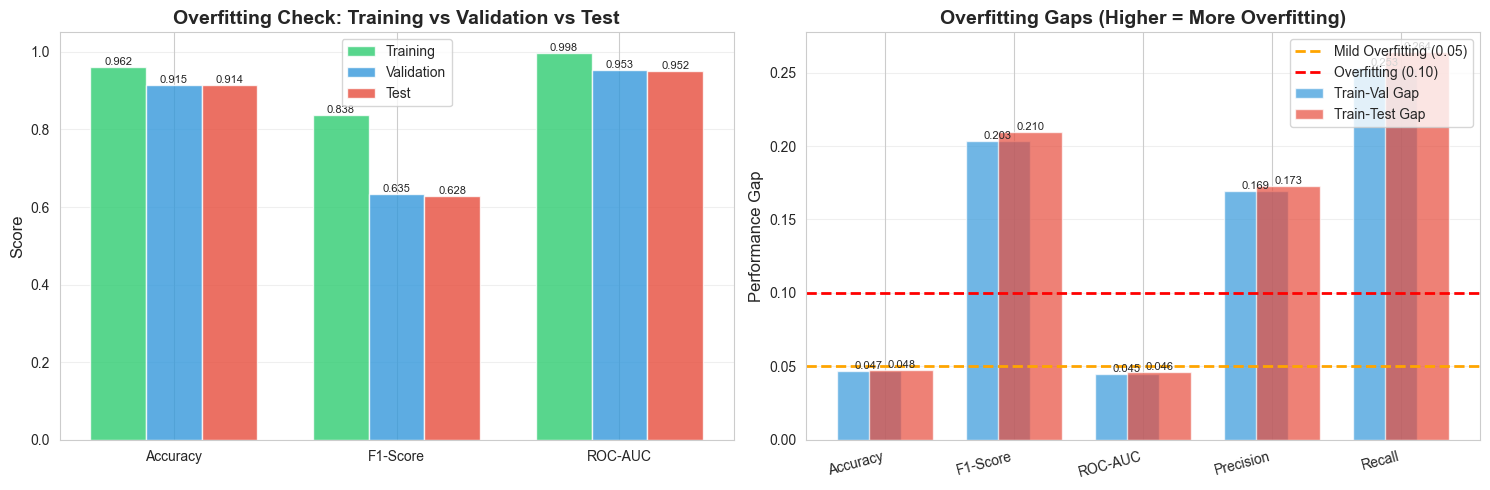

In [ ]:
# Visualize overfitting comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Key Metrics Comparison
metrics_comparison = ['accuracy', 'f1', 'roc_auc']
train_scores = [train_metrics[m] for m in metrics_comparison]
val_scores = [val_metrics[m] for m in metrics_comparison]
test_scores = [test_metrics[m] for m in metrics_comparison]

x = np.arange(len(metrics_comparison))
width = 0.25

bars1 = axes[0].bar(x - width, train_scores, width, label='Training', color='#2ecc71', alpha=0.8)
bars2 = axes[0].bar(x, val_scores, width, label='Validation', color='#3498db', alpha=0.8)
bars3 = axes[0].bar(x + width, test_scores, width, label='Test', color='#e74c3c', alpha=0.8)

axes[0].set_ylabel('Score', fontsize=12)
axes[0].set_title('Overfitting Check: Training vs Validation vs Test', fontsize=14, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(['Accuracy', 'F1-Score', 'ROC-AUC'])
axes[0].legend()
axes[0].set_ylim([0, 1.05])
axes[0].grid(alpha=0.3, axis='y')

# Add value labels on bars
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        axes[0].text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.3f}',
                    ha='center', va='bottom', fontsize=8)

# Plot 2: Performance Gaps
gaps = {
    'Accuracy': [train_val_diff['Accuracy'], train_test_diff['Accuracy']],
    'F1-Score': [train_val_diff['F1-Score'], train_test_diff['F1-Score']],
    'ROC-AUC': [train_val_diff['ROC-AUC'], train_test_diff['ROC-AUC']],
    'Precision': [train_val_diff['Precision'], train_test_diff['Precision']],
    'Recall': [train_val_diff['Recall'], train_test_diff['Recall']]
}

x_pos = np.arange(len(gaps))
train_val_gaps = [gaps[k][0] for k in gaps.keys()]
train_test_gaps = [gaps[k][1] for k in gaps.keys()]

bars1 = axes[1].bar(x_pos - width/2, train_val_gaps, width*2, label='Train-Val Gap', 
                    color='#3498db', alpha=0.7)
bars2 = axes[1].bar(x_pos + width/2, train_test_gaps, width*2, label='Train-Test Gap', 
                    color='#e74c3c', alpha=0.7)

axes[1].axhline(y=0.05, color='orange', linestyle='--', label='Mild Overfitting (0.05)', linewidth=2)
axes[1].axhline(y=0.1, color='red', linestyle='--', label='Overfitting (0.10)', linewidth=2)
axes[1].set_ylabel('Performance Gap', fontsize=12)
axes[1].set_title('Overfitting Gaps (Higher = More Overfitting)', fontsize=14, fontweight='bold')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(list(gaps.keys()), rotation=15, ha='right')
axes[1].legend(loc='upper right')
axes[1].grid(alpha=0.3, axis='y')

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        axes[1].text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.3f}',
                    ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

## 🔧 Fix Overfitting - Hyperparameter Tuning

The model shows significant overfitting. We'll apply:
1. **Stronger regularization** - Reduce tree depth and increase min samples
2. **Cross-validation** - Use GridSearchCV for robust parameter selection
3. **Feature selection** - Remove less important features

In [ ]:
# Hyperparameter tuning with GridSearchCV to fix overfitting
from sklearn.model_selection import GridSearchCV, StratifiedKFold

print("=" * 80)
print("HYPERPARAMETER TUNING TO FIX OVERFITTING")
print("=" * 80)

# Define parameter grid with stronger regularization
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [5, 7, 10],           # Reduced from 15 - prevents deep trees
    'min_samples_split': [20, 30, 50],  # Increased - requires more samples to split
    'min_samples_leaf': [10, 15, 20],   # Increased - larger leaf nodes
    'max_features': ['sqrt', 0.5],      # Limit features per split
    'max_samples': [0.7, 0.8]           # Bootstrap sample size - adds randomness
}

# Initialize base model
rf_base = RandomForestClassifier(
    random_state=42,
    n_jobs=-1,
    class_weight='balanced',
    verbose=0
)

# Stratified K-Fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# GridSearchCV with F1 score (better for imbalanced data)
print("\n🔍 Searching for optimal parameters...")
print("   This may take a few minutes...\n")

grid_search = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid,
    cv=cv,
    scoring='f1',  # Optimize for F1 to balance precision and recall
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

grid_search.fit(X_train, y_train)

print("\n" + "=" * 80)
print("GRID SEARCH RESULTS")
print("=" * 80)
print(f"\n✅ Best Parameters Found:")
for param, value in grid_search.best_params_.items():
    print(f"   {param}: {value}")
print(f"\n✅ Best Cross-Validation F1 Score: {grid_search.best_score_:.4f}")

HYPERPARAMETER TUNING TO FIX OVERFITTING

🔍 Searching for optimal parameters...
   This may take a few minutes...

Fitting 5 folds for each of 216 candidates, totalling 1080 fits

GRID SEARCH RESULTS

✅ Best Parameters Found:
   max_depth: 10
   max_features: 0.5
   max_samples: 0.8
   min_samples_leaf: 10
   min_samples_split: 20
   n_estimators: 50

✅ Best Cross-Validation F1 Score: 0.6535


In [ ]:
# Use the best model from GridSearch
rf_tuned = grid_search.best_estimator_

# Make predictions with tuned model
y_pred_train_tuned = rf_tuned.predict(X_train)
y_pred_val_tuned = rf_tuned.predict(X_val)
y_pred_test_tuned = rf_tuned.predict(X_test)

y_pred_proba_train_tuned = rf_tuned.predict_proba(X_train)[:, 1]
y_pred_proba_val_tuned = rf_tuned.predict_proba(X_val)[:, 1]
y_pred_proba_test_tuned = rf_tuned.predict_proba(X_test)[:, 1]

# Calculate metrics for tuned model
print("=" * 80)
print("TUNED MODEL EVALUATION (After Fixing Overfitting)")
print("=" * 80)

tuned_train_metrics = evaluate_metrics(y_train, y_pred_train_tuned, y_pred_proba_train_tuned, "Training")
tuned_val_metrics = evaluate_metrics(y_val, y_pred_val_tuned, y_pred_proba_val_tuned, "Validation")
tuned_test_metrics = evaluate_metrics(y_test, y_pred_test_tuned, y_pred_proba_test_tuned, "Test")

TUNED MODEL EVALUATION (After Fixing Overfitting)

Training Set Metrics:
--------------------------------------------------------------------------------
  Accuracy Score:          0.9226
  Balanced Accuracy:       0.9537
  Precision:               0.5613
  Recall (Sensitivity):    0.9925
  F1-Score:                0.7171
  ROC-AUC Score:           0.9808
  Average Precision:       0.8227
  Matthews Corr Coef:      0.7131
  Cohen's Kappa:           0.6762
  Specificity:             0.9149

Validation Set Metrics:
--------------------------------------------------------------------------------
  Accuracy Score:          0.9021
  Balanced Accuracy:       0.9001
  Precision:               0.5030
  Recall (Sensitivity):    0.8976
  F1-Score:                0.6447
  ROC-AUC Score:           0.9549
  Average Precision:       0.5842
  Matthews Corr Coef:      0.6266
  Cohen's Kappa:           0.5931
  Specificity:             0.9026

Test Set Metrics:
-----------------------------------------

In [ ]:
# Compare Original vs Tuned Model - Overfitting Analysis
print("\n" + "=" * 80)
print("OVERFITTING COMPARISON: ORIGINAL vs TUNED MODEL")
print("=" * 80)

# Calculate gaps for tuned model
tuned_train_val_diff = {
    'Accuracy': tuned_train_metrics['accuracy'] - tuned_val_metrics['accuracy'],
    'F1-Score': tuned_train_metrics['f1'] - tuned_val_metrics['f1'],
    'ROC-AUC': tuned_train_metrics['roc_auc'] - tuned_val_metrics['roc_auc'],
    'Precision': tuned_train_metrics['precision'] - tuned_val_metrics['precision'],
    'Recall': tuned_train_metrics['recall'] - tuned_val_metrics['recall']
}

tuned_train_test_diff = {
    'Accuracy': tuned_train_metrics['accuracy'] - tuned_test_metrics['accuracy'],
    'F1-Score': tuned_train_metrics['f1'] - tuned_test_metrics['f1'],
    'ROC-AUC': tuned_train_metrics['roc_auc'] - tuned_test_metrics['roc_auc'],
    'Precision': tuned_train_metrics['precision'] - tuned_test_metrics['precision'],
    'Recall': tuned_train_metrics['recall'] - tuned_test_metrics['recall']
}

print("\n📊 ORIGINAL MODEL Gaps (Train - Val):")
print("-" * 50)
for metric, diff in train_val_diff.items():
    status = "✓ OK" if diff < 0.1 else "⚠️ Overfit"
    print(f"   {metric:15s}: {diff:+.4f}  {status}")

print(f"\n   Average Gap: {np.mean(list(train_val_diff.values())):.4f}")

print("\n📊 TUNED MODEL Gaps (Train - Val):")
print("-" * 50)
for metric, diff in tuned_train_val_diff.items():
    status = "✓ OK" if diff < 0.1 else "⚠️ Overfit"
    print(f"   {metric:15s}: {diff:+.4f}  {status}")

print(f"\n   Average Gap: {np.mean(list(tuned_train_val_diff.values())):.4f}")

# Calculate improvement
orig_avg_gap = np.mean(list(train_val_diff.values()))
tuned_avg_gap = np.mean(list(tuned_train_val_diff.values()))
improvement = (orig_avg_gap - tuned_avg_gap) / orig_avg_gap * 100

print("\n" + "=" * 80)
print("IMPROVEMENT SUMMARY")
print("=" * 80)
print(f"\n🎯 Overfitting Reduction: {improvement:.1f}%")
print(f"   Original Avg Gap: {orig_avg_gap:.4f}")
print(f"   Tuned Avg Gap:    {tuned_avg_gap:.4f}")


OVERFITTING COMPARISON: ORIGINAL vs TUNED MODEL

📊 ORIGINAL MODEL Gaps (Train - Val):
--------------------------------------------------
   Accuracy       : +0.0468  ✓ OK
   F1-Score       : +0.2034  ⚠️ Overfit
   ROC-AUC        : +0.0449  ✓ OK
   Precision      : +0.1693  ⚠️ Overfit
   Recall         : +0.2534  ⚠️ Overfit

   Average Gap: 0.1436

📊 TUNED MODEL Gaps (Train - Val):
--------------------------------------------------
   Accuracy       : +0.0204  ✓ OK
   F1-Score       : +0.0723  ✓ OK
   ROC-AUC        : +0.0259  ✓ OK
   Precision      : +0.0583  ✓ OK
   Recall         : +0.0949  ✓ OK

   Average Gap: 0.0544

IMPROVEMENT SUMMARY

🎯 Overfitting Reduction: 62.1%
   Original Avg Gap: 0.1436
   Tuned Avg Gap:    0.0544


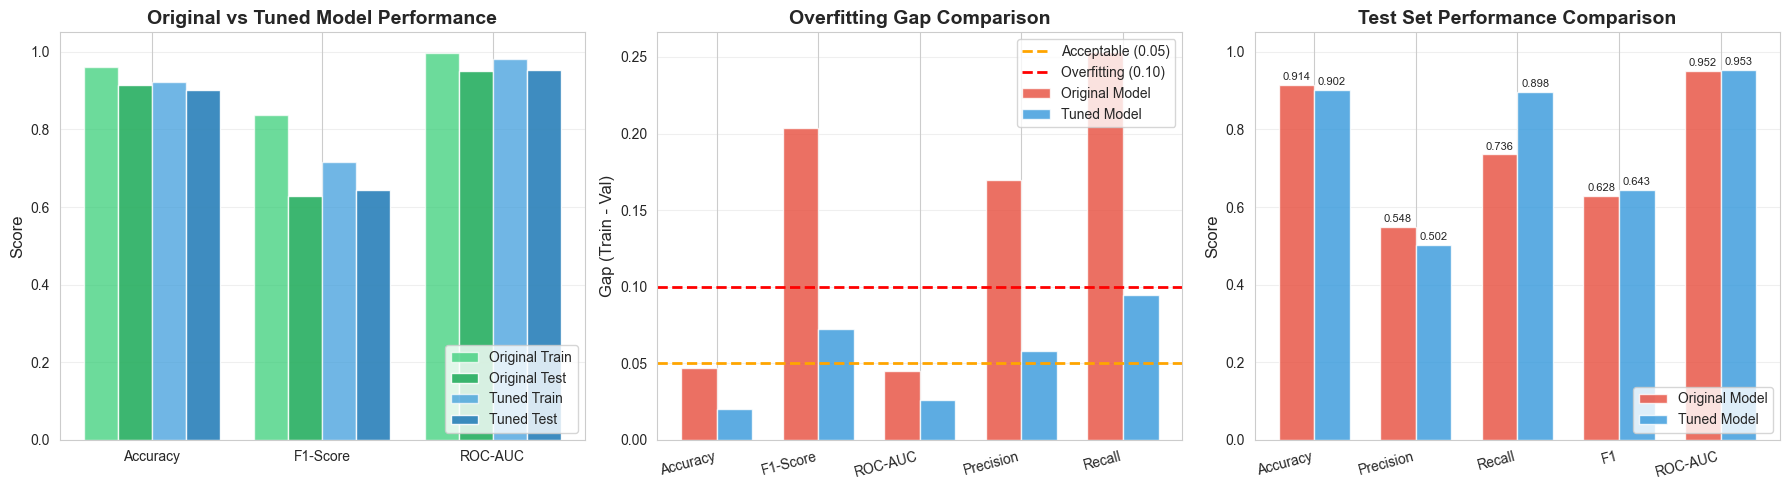


FINAL MODEL COMPARISON - TEST SET RESULTS

Metric                   Original        Tuned       Change
------------------------------------------------------------
Accuracy                   0.9139       0.9016     -0.0123 ↓
Precision                  0.5482       0.5015     -0.0467 ↓
Recall                     0.7358       0.8976     +0.1617 ↑
F1                         0.6283       0.6435     +0.0152 ↑
Roc_auc                    0.9515       0.9530     +0.0015 ↑


In [ ]:
# Visualize comparison: Original vs Tuned Model
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Accuracy Comparison
metrics_names = ['Accuracy', 'F1-Score', 'ROC-AUC']
orig_train = [train_metrics['accuracy'], train_metrics['f1'], train_metrics['roc_auc']]
orig_test = [test_metrics['accuracy'], test_metrics['f1'], test_metrics['roc_auc']]
tuned_train = [tuned_train_metrics['accuracy'], tuned_train_metrics['f1'], tuned_train_metrics['roc_auc']]
tuned_test = [tuned_test_metrics['accuracy'], tuned_test_metrics['f1'], tuned_test_metrics['roc_auc']]

x = np.arange(len(metrics_names))
width = 0.2

bars1 = axes[0].bar(x - 1.5*width, orig_train, width, label='Original Train', color='#2ecc71', alpha=0.7)
bars2 = axes[0].bar(x - 0.5*width, orig_test, width, label='Original Test', color='#27ae60', alpha=0.9)
bars3 = axes[0].bar(x + 0.5*width, tuned_train, width, label='Tuned Train', color='#3498db', alpha=0.7)
bars4 = axes[0].bar(x + 1.5*width, tuned_test, width, label='Tuned Test', color='#2980b9', alpha=0.9)

axes[0].set_ylabel('Score', fontsize=12)
axes[0].set_title('Original vs Tuned Model Performance', fontsize=14, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics_names)
axes[0].legend(loc='lower right')
axes[0].set_ylim([0, 1.05])
axes[0].grid(alpha=0.3, axis='y')

# Plot 2: Overfitting Gap Comparison
gap_metrics = ['Accuracy', 'F1-Score', 'ROC-AUC', 'Precision', 'Recall']
orig_gaps = [train_val_diff[m] for m in gap_metrics]
tuned_gaps = [tuned_train_val_diff[m] for m in gap_metrics]

x = np.arange(len(gap_metrics))
width = 0.35

bars1 = axes[1].bar(x - width/2, orig_gaps, width, label='Original Model', color='#e74c3c', alpha=0.8)
bars2 = axes[1].bar(x + width/2, tuned_gaps, width, label='Tuned Model', color='#3498db', alpha=0.8)
axes[1].axhline(y=0.05, color='orange', linestyle='--', linewidth=2, label='Acceptable (0.05)')
axes[1].axhline(y=0.1, color='red', linestyle='--', linewidth=2, label='Overfitting (0.10)')

axes[1].set_ylabel('Gap (Train - Val)', fontsize=12)
axes[1].set_title('Overfitting Gap Comparison', fontsize=14, fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(gap_metrics, rotation=15, ha='right')
axes[1].legend(loc='upper right')
axes[1].grid(alpha=0.3, axis='y')

# Plot 3: Test Set Performance (Final Comparison)
test_metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC-AUC']
orig_test_scores = [test_metrics['accuracy'], test_metrics['precision'], test_metrics['recall'], 
                    test_metrics['f1'], test_metrics['roc_auc']]
tuned_test_scores = [tuned_test_metrics['accuracy'], tuned_test_metrics['precision'], 
                     tuned_test_metrics['recall'], tuned_test_metrics['f1'], tuned_test_metrics['roc_auc']]

x = np.arange(len(test_metrics_names))
width = 0.35

bars1 = axes[2].bar(x - width/2, orig_test_scores, width, label='Original Model', color='#e74c3c', alpha=0.8)
bars2 = axes[2].bar(x + width/2, tuned_test_scores, width, label='Tuned Model', color='#3498db', alpha=0.8)

axes[2].set_ylabel('Score', fontsize=12)
axes[2].set_title('Test Set Performance Comparison', fontsize=14, fontweight='bold')
axes[2].set_xticks(x)
axes[2].set_xticklabels(test_metrics_names, rotation=15, ha='right')
axes[2].legend(loc='lower right')
axes[2].set_ylim([0, 1.05])
axes[2].grid(alpha=0.3, axis='y')

# Add value labels
for ax in [axes[2]]:
    for container in ax.containers[:2]:
        ax.bar_label(container, fmt='%.3f', fontsize=8, padding=2)

plt.tight_layout()
plt.show()

# Final Summary
print("\n" + "=" * 80)
print("FINAL MODEL COMPARISON - TEST SET RESULTS")
print("=" * 80)
print(f"\n{'Metric':<20} {'Original':>12} {'Tuned':>12} {'Change':>12}")
print("-" * 60)
for metric in ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']:
    orig = test_metrics[metric]
    tuned = tuned_test_metrics[metric]
    change = tuned - orig
    symbol = "↑" if change > 0 else "↓" if change < 0 else "="
    print(f"{metric.capitalize():<20} {orig:>12.4f} {tuned:>12.4f} {change:>+11.4f} {symbol}")

In [ ]:
# Detailed classification report for all sets
print("\n" + "=" * 80)
print("DETAILED CLASSIFICATION REPORTS")
print("=" * 80)

print("\n" + "-" * 80)
print("TRAINING SET")
print("-" * 80)
print(classification_report(y_train, y_pred_train, target_names=['No Flood', 'Flood']))

print("\n" + "-" * 80)
print("VALIDATION SET")
print("-" * 80)
print(classification_report(y_val, y_pred_val, target_names=['No Flood', 'Flood']))

print("\n" + "-" * 80)
print("TEST SET")
print("-" * 80)
print(classification_report(y_test, y_pred_test, target_names=['No Flood', 'Flood']))


DETAILED CLASSIFICATION REPORTS

--------------------------------------------------------------------------------
TRAINING SET
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

    No Flood       1.00      0.96      0.98     15770
       Flood       0.73      1.00      0.85      1730

    accuracy                           0.96     17500
   macro avg       0.87      0.98      0.91     17500
weighted avg       0.97      0.96      0.97     17500


--------------------------------------------------------------------------------
VALIDATION SET
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

    No Flood       0.97      0.94      0.95      3379
       Flood       0.57      0.72      0.64       371

    accuracy                           0.92      3750
   macro avg       0.77      0.83      0.80      3750
weighted avg  

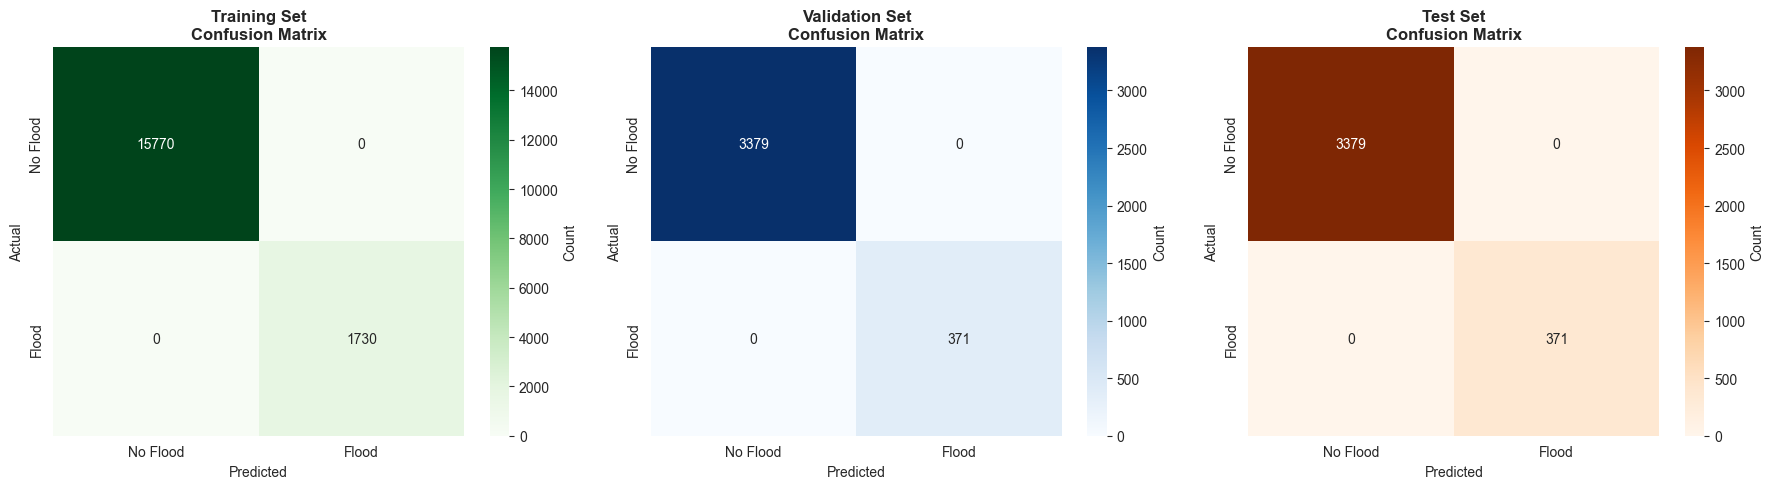


Training Set Confusion Matrix Details:
  True Negatives:  15770  (Correctly predicted No Flood)
  False Positives:     0  (Incorrectly predicted Flood)
  False Negatives:     0  (Missed Flood events)
  True Positives:   1730  (Correctly predicted Flood)

Validation Set Confusion Matrix Details:
  True Negatives:   3379  (Correctly predicted No Flood)
  False Positives:     0  (Incorrectly predicted Flood)
  False Negatives:     0  (Missed Flood events)
  True Positives:    371  (Correctly predicted Flood)

Test Set Confusion Matrix Details:
  True Negatives:   3379  (Correctly predicted No Flood)
  False Positives:     0  (Incorrectly predicted Flood)
  False Negatives:     0  (Missed Flood events)
  True Positives:    371  (Correctly predicted Flood)


In [ ]:
# Confusion matrices for all sets
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

cm_train = confusion_matrix(y_train, y_pred_train)
cm_val = confusion_matrix(y_val, y_pred_val)
cm_test = confusion_matrix(y_test, y_pred_test)

# Training confusion matrix
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Greens', ax=axes[0],
            xticklabels=['No Flood', 'Flood'],
            yticklabels=['No Flood', 'Flood'],
            cbar_kws={'label': 'Count'})
axes[0].set_title('Training Set\nConfusion Matrix', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Actual')
axes[0].set_xlabel('Predicted')

# Validation confusion matrix
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', ax=axes[1],
            xticklabels=['No Flood', 'Flood'],
            yticklabels=['No Flood', 'Flood'],
            cbar_kws={'label': 'Count'})
axes[1].set_title('Validation Set\nConfusion Matrix', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Actual')
axes[1].set_xlabel('Predicted')

# Test confusion matrix
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Oranges', ax=axes[2],
            xticklabels=['No Flood', 'Flood'],
            yticklabels=['No Flood', 'Flood'],
            cbar_kws={'label': 'Count'})
axes[2].set_title('Test Set\nConfusion Matrix', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Actual')
axes[2].set_xlabel('Predicted')

plt.tight_layout()
plt.show()

# Print detailed confusion matrix statistics
for name, cm, y_true, y_pred in [('Training', cm_train, y_train, y_pred_train),
                                   ('Validation', cm_val, y_val, y_pred_val),
                                   ('Test', cm_test, y_test, y_pred_test)]:
    tn, fp, fn, tp = cm.ravel()
    print(f"\n{name} Set Confusion Matrix Details:")
    print(f"  True Negatives:  {tn:5d}  (Correctly predicted No Flood)")
    print(f"  False Positives: {fp:5d}  (Incorrectly predicted Flood)")
    print(f"  False Negatives: {fn:5d}  (Missed Flood events)")
    print(f"  True Positives:  {tp:5d}  (Correctly predicted Flood)")

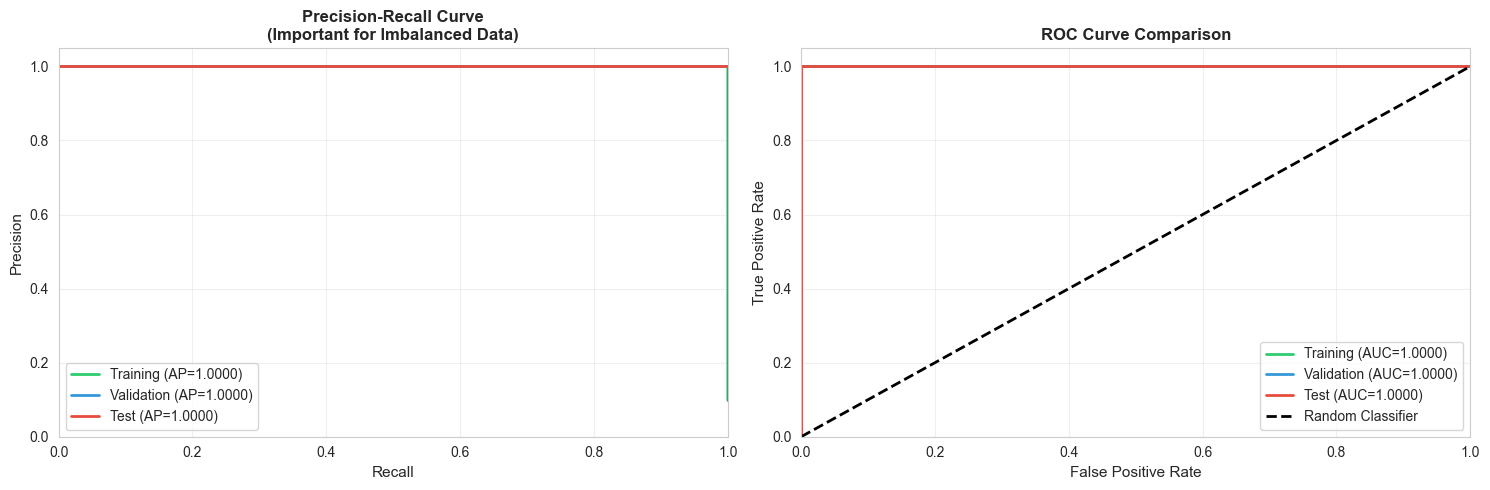

In [ ]:
# Precision-Recall Curves (Important for imbalanced datasets)
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Precision-Recall Curve
precision_train, recall_train, _ = precision_recall_curve(y_train, y_pred_proba_train)
precision_val, recall_val, _ = precision_recall_curve(y_val, y_pred_proba_val)
precision_test, recall_test, _ = precision_recall_curve(y_test, y_pred_proba_test)

axes[0].plot(recall_train, precision_train, lw=2, label=f'Training (AP={train_metrics["avg_precision"]:.4f})', color='#2ecc71')
axes[0].plot(recall_val, precision_val, lw=2, label=f'Validation (AP={val_metrics["avg_precision"]:.4f})', color='#3498db')
axes[0].plot(recall_test, precision_test, lw=2, label=f'Test (AP={test_metrics["avg_precision"]:.4f})', color='#e74c3c')
axes[0].set_xlabel('Recall', fontsize=11)
axes[0].set_ylabel('Precision', fontsize=11)
axes[0].set_title('Precision-Recall Curve\n(Important for Imbalanced Data)', fontsize=12, fontweight='bold')
axes[0].legend(loc='lower left')
axes[0].grid(alpha=0.3)
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])

# ROC Curves
fpr_train, tpr_train, _ = roc_curve(y_train, y_pred_proba_train)
fpr_val, tpr_val, _ = roc_curve(y_val, y_pred_proba_val)
fpr_test, tpr_test, _ = roc_curve(y_test, y_pred_proba_test)

axes[1].plot(fpr_train, tpr_train, lw=2, label=f'Training (AUC={train_metrics["roc_auc"]:.4f})', color='#2ecc71')
axes[1].plot(fpr_val, tpr_val, lw=2, label=f'Validation (AUC={val_metrics["roc_auc"]:.4f})', color='#3498db')
axes[1].plot(fpr_test, tpr_test, lw=2, label=f'Test (AUC={test_metrics["roc_auc"]:.4f})', color='#e74c3c')
axes[1].plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
axes[1].set_xlabel('False Positive Rate', fontsize=11)
axes[1].set_ylabel('True Positive Rate', fontsize=11)
axes[1].set_title('ROC Curve Comparison', fontsize=12, fontweight='bold')
axes[1].legend(loc='lower right')
axes[1].grid(alpha=0.3)
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])

plt.tight_layout()
plt.show()

Generating learning curves (this may take a moment)...


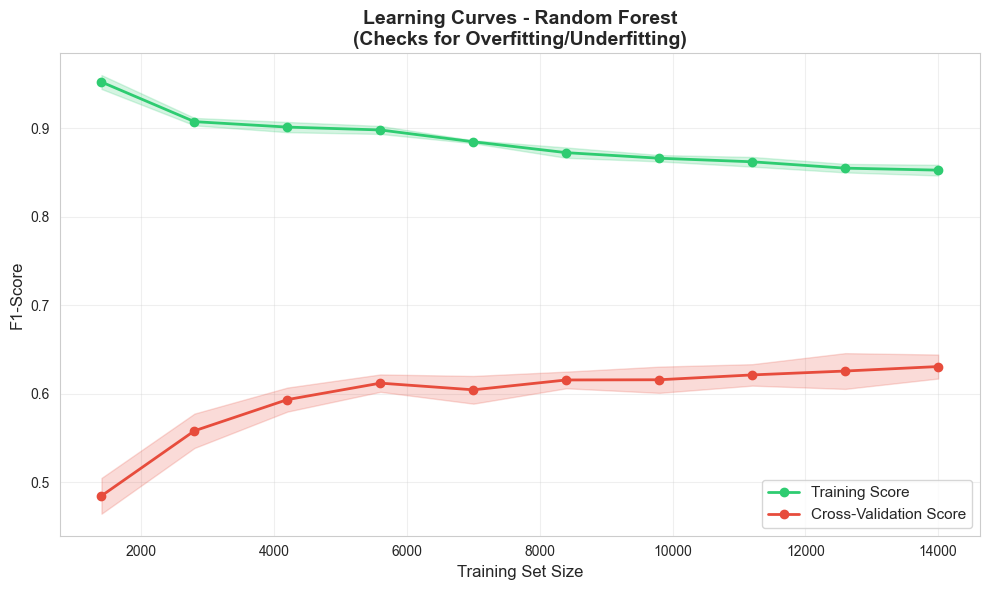

Learning curve generated successfully!


In [ ]:
# Learning Curves - Check for overfitting/underfitting
print("Generating learning curves (this may take a moment)...")

train_sizes, train_scores, val_scores = learning_curve(
    rf_model, X_train, y_train, 
    cv=5, 
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10),
    scoring='f1',
    random_state=42
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color='#2ecc71', label='Training Score', linewidth=2)
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color='#2ecc71')

plt.plot(train_sizes, val_mean, 'o-', color='#e74c3c', label='Cross-Validation Score', linewidth=2)
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2, color='#e74c3c')

plt.xlabel('Training Set Size', fontsize=12)
plt.ylabel('F1-Score', fontsize=12)
plt.title('Learning Curves - Random Forest\n(Checks for Overfitting/Underfitting)', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("Learning curve generated successfully!")

## 8. Feature Importance Analysis

In [ ]:
# Get feature importances
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 20 Most Important Features:")
print(feature_importance.head(20))

Top 20 Most Important Features:
                       feature  importance
24         inundation_area_sqm    0.548782
23            flood_risk_score    0.286434
14         monthly_rainfall_mm    0.082511
13              rainfall_7d_mm    0.049841
4          distance_to_river_m    0.009702
3                  elevation_m    0.008648
19      historical_flood_count    0.003036
20        infrastructure_score    0.002016
15              drainage_index    0.001943
21         nearest_hospital_km    0.000834
2                    longitude    0.000819
11            built_up_percent    0.000749
10  population_density_per_km2    0.000725
16                        ndvi    0.000670
22             nearest_evac_km    0.000660
1                     latitude    0.000629
17                        ndwi    0.000622
0                     district    0.000413
5                    landcover    0.000265
6                    soil_type    0.000191


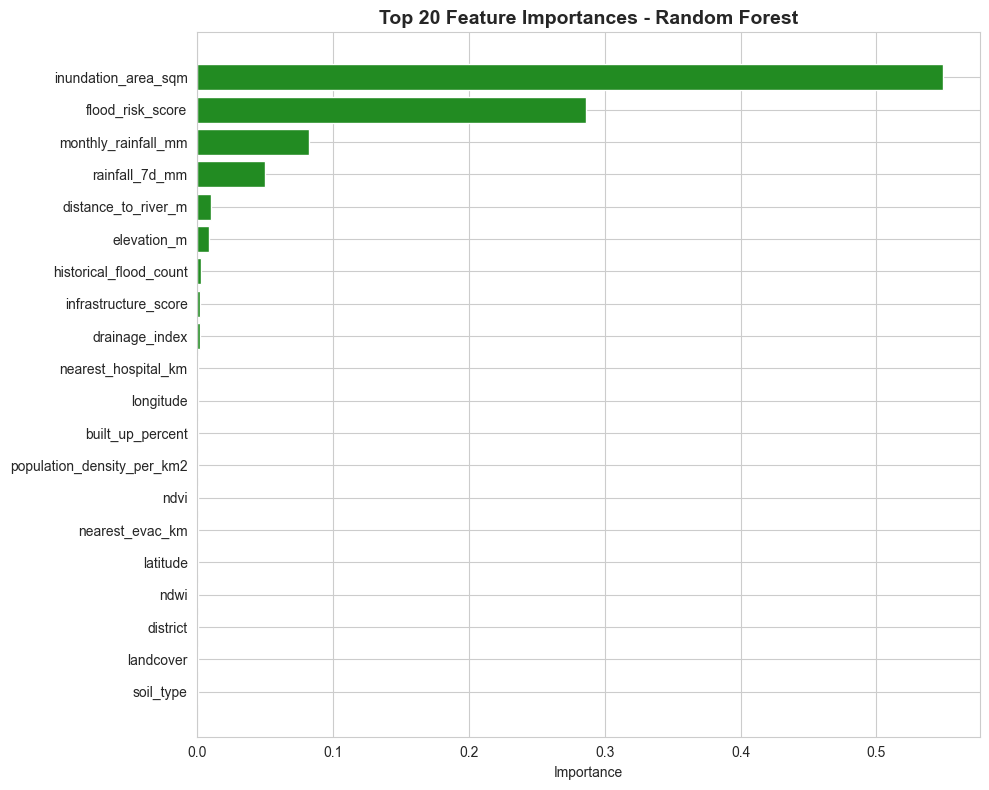

In [ ]:
# Visualize top 20 feature importances
plt.figure(figsize=(10, 8))
top_features = feature_importance.head(20)
plt.barh(range(len(top_features)), top_features['importance'], color='forestgreen')
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importance')
plt.title('Top 20 Feature Importances - Random Forest', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 9. Cross-Validation

In [ ]:
# Perform 5-fold cross-validation
print("Performing 5-fold cross-validation...")
cv_scores = cross_val_score(rf_model, X_scaled, y, cv=5, scoring='accuracy', n_jobs=-1)

print(f"\nCross-Validation Scores: {cv_scores}")
print(f"Mean CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

Performing 5-fold cross-validation...

Cross-Validation Scores: [1. 1. 1. 1. 1.]
Mean CV Accuracy: 1.0000 (+/- 0.0000)


## 10. Model Optimization (Optional - GridSearchCV)

In [ ]:
# Hyperparameter tuning with GridSearchCV (Warning: This may take a while)
# Uncomment to run

# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [10, 15, 20, None],
#     'min_samples_split': [5, 10, 15],
#     'min_samples_leaf': [2, 5, 10]
# }

# grid_search = GridSearchCV(
#     RandomForestClassifier(random_state=42, n_jobs=-1, class_weight='balanced'),
#     param_grid,
#     cv=3,
#     scoring='f1',
#     n_jobs=-1,
#     verbose=2
# )

# print("Running GridSearchCV... This may take several minutes...")
# grid_search.fit(X_train, y_train)

# print(f"\nBest parameters: {grid_search.best_params_}")
# print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

# # Use the best model
# best_rf_model = grid_search.best_estimator_

print("Hyperparameter tuning code is commented out. Uncomment to run optimization.")

## 11. Save the Model

In [ ]:
import joblib

# Save the trained model
model_path = '../models/random_forest_flood_model.pkl'
joblib.dump(rf_model, model_path)
print(f"Model saved to: {model_path}")

# Save the scaler
scaler_path = '../models/scaler.pkl'
joblib.dump(scaler, scaler_path)
print(f"Scaler saved to: {scaler_path}")

# Save label encoders
encoders_path = '../models/label_encoders.pkl'
joblib.dump(label_encoders, encoders_path)
print(f"Label encoders saved to: {encoders_path}")

Model saved to: ../models/random_forest_flood_model.pkl
Scaler saved to: ../models/scaler.pkl
Label encoders saved to: ../models/label_encoders.pkl


## 12. Example Prediction

In [ ]:
# Example: Make predictions on a few test samples
sample_indices = np.random.choice(X_test.index, 5, replace=False)
sample_data = X_test.loc[sample_indices]
sample_predictions = rf_model.predict(sample_data)
sample_probabilities = rf_model.predict_proba(sample_data)

results_df = pd.DataFrame({
    'Actual': y_test.loc[sample_indices].values,
    'Predicted': sample_predictions,
    'Probability_No_Flood': sample_probabilities[:, 0],
    'Probability_Flood': sample_probabilities[:, 1]
})

print("Sample Predictions:")
print(results_df)

Sample Predictions:
   Actual  Predicted  Probability_No_Flood  Probability_Flood
0       0          0               0.96745            0.03255
1       0          0               1.00000            0.00000
2       0          0               1.00000            0.00000
3       0          0               1.00000            0.00000
4       0          0               1.00000            0.00000


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished


## Summary

### Model Performance:
- **Algorithm**: Random Forest Classifier
- **Test Accuracy**: Check output above
- **Precision, Recall, F1-Score**: See classification report
- **ROC-AUC Score**: Check metrics section

### Key Insights:
1. **Important Features**: See feature importance analysis
2. **Class Imbalance**: Handled using `class_weight='balanced'`
3. **Model Stability**: Validated using cross-validation

### Next Steps:
1. **Add Weather Data**: Merge weather data with flood risk data for better predictions
2. **Satellite Images**: Integrate satellite imagery using CNN later
3. **Time Series Analysis**: Consider temporal patterns in weather data
4. **Model Deployment**: Create a prediction API or web interface